In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import os
import sys
import json

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import font_manager
import numpy as np

%matplotlib inline


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/vscode/.cache/pypoetry/virtualenvs/winc-onepager-kkKEUEKl-py3.12/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/vscode/.cache/pypoetry/virtualenvs/winc-onepager-kkKEUEKl-py3.12/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/vscode/.cache/pypoetry/virtualenvs/win

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/vscode/.cache/pypoetry/virtualenvs/winc-onepager-kkKEUEKl-py3.12/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/vscode/.cache/pypoetry/virtualenvs/winc-onepager-kkKEUEKl-py3.12/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/vscode/.cache/pypoetry/virtualenvs/win

AttributeError: _ARRAY_API not found

In [3]:
# resource configuration
rcParams['figure.dpi'] = 200

# fount information
rcParams['font.family'] = 'Equinor'
rcParams['font.size'] = 9

# fornt location
font_path = r'Equinor_regular'
font_files = font_manager.findSystemFonts(fontpaths=font_path)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [4]:
# where WellClass and Ga[ codes are located
sys.path.append('../')

In [5]:
# WellClass
# from well_class_v2 import csv_parser, Well
from src.WellClass.libs.utils import (
    csv_parser,
    yaml_parser
)

from src.WellClass.libs.well_class import Well
from src.WellClass.libs.well_pressure import Pressure

# plots
from src.WellClass.libs.plotting import (
    plot_pressure,
    plot_pt,
    plot_sketch,
)

## Some user options

In [6]:
# use yaml or csv input file
use_yaml = True

In [7]:
# pick an example from given three options

case_type = 'wildcat'

case_type = 'smeaheia_v1'

# case_type = 'smeaheia_v2'

In [8]:
# where pvt located
pvt_path = '../src/WellClass/libs/pvt/pvt_constants/pure_co2'

# Examples

The following are the test examples.

In [9]:
# examples
smeaheia_v1 = {'well_input': r'GaP_input_Smeaheia_v3.csv', 
               'well_input_yaml': r'smeaheia.yaml', 
            #    'sim_path': r'/scratch/SCS/eim/SMEAHEIA', 
               'sim_path': r'../test_data/examples/smeaheia_v1',
               'simcase': r'GEN_NOLGR_PH2'}
smeaheia_v2 = {'well_input': r'GaP_input_Smeaheia_v3.csv', 
               'well_input_yaml': r'smeaheia.yaml', 
            #    'sim_path': r'/scratch/SCS/bkh/wbook/realization-0/iter-0/pflotran/model', 
               'sim_path': r'../test_data/examples/smeaheia_v2', 
               'simcase': r'TEMP-0'}
wildcat = {
         'well_input': r'GaP_input_Wildcat_v3.csv', 
         'well_input_yaml': r'wildcat.yaml', 
        #  'sim_path': r'/scratch/SCS/bkh/well_class_test1/realization-0/iter-0/pflotran/model', 
         'sim_path': r'../test_data/examples/wildcat', 
         'simcase': r'TEMP-0'}

In [10]:
examples = {
    'smeaheia_v1': smeaheia_v1,
    'smeaheia_v2': smeaheia_v2,
    'wildcat': wildcat
}

# Load well CSV or yaml configuration file

Process CSV with well class.
Predefine a dictionary that includes the input CSV well file, the simulation path, and the PFT sim case name

In [11]:
# the selected example for testing
case = examples[case_type]


In [12]:

# root_path = '/scratch/SCS/gpb/SCREEN/GaP_code'

sim_path = case['sim_path']


In [13]:
if use_yaml:
    # where well configuration file is located
    well_name = os.path.join(sim_path, case['well_input_yaml'])
    
    # # pydantic model
    well_model = yaml_parser(well_name)
    well_csv = json.loads(well_model.spec.model_dump_json())
else:
    # where well configuration file is located
    well_name = os.path.join(sim_path, case['well_input'])

    # load the well information
    well_csv = csv_parser(well_name)

In [14]:
#Process well by running well class
my_well = Well( header       = well_csv['well_header'], 
                drilling     = well_csv['drilling'],
                casings      = well_csv['casing_cement'],
                geology      = well_csv['geology'],
                barriers     = well_csv['barriers'], 
                barrier_perm = well_csv['barrier_permeability'],
                co2_datum    = well_csv['co2_datum'],
           )

In [15]:
my_well.header

{'well_name': 'NO 32/4-1',
 'well_rkb': 23.5,
 'sf_depth_msl': 312,
 'well_td_rkb': 3186,
 'sf_temp': 4,
 'geo_tgrad': 40}

In [16]:
well_csv['reservoir_pressure']

{'depth_msl': 1217, 'RP1': None, 'RP2': '91', 'RP3': '20'}

## Generation of Pressure tables
### 1. Minimum input: 

The pressure class can be initialized with a minimum of the following parameters:
- Depth to seabed in mTVDMSL
- Wellbore TD in mRKB
- Wellbore RKB in mTVDMSL
- Seafloor temperature in degC. Defaulted to 4 degC
- Geothermal gradient in degC/km. Defaulted to 40 degC/km
- Fluid type: This depends on the PVT tables available on pvtpath 
  - pure CO2, Components: 100% CO2
  - pure C1, Components: 100% CH4
  - mixture 1, Components: 96% CO2, 0.4% H, 1% Ar, 0.82% N, 1.78% CH4
  - mixture 2, Components: 95% CO2, 5% CH4
- Path to the PVT tables


In [17]:

from src.WellClass.libs.well_pressure.new_Pressure import Pressure
from src.WellClass.libs.well_pressure.new_PressureScenarioManager import PressureScenarioManager
from src.WellClass.libs.well_pressure.new_PressureScenario import PressureScenario
from src.WellClass.libs.well_pressure.new_aux_func import get_rho_from_pvt_data, load_pvt_data, _integrate_pressure



my_pressure = Pressure(sf_depth_msl=well_csv['well_header']['sf_depth_msl'],
                       well_td_rkb=well_csv['well_header']['well_td_rkb'],
                       well_rkb=well_csv['well_header']['well_rkb'],
                       sf_temp=well_csv['well_header']['sf_temp'],
                       geo_tgrad=well_csv['well_header']['geo_tgrad'],
                       fluid_type='pure_co2',
                       pvt_path='../src/WellClass/libs/pvt/pvt_constants')

[1621.5]


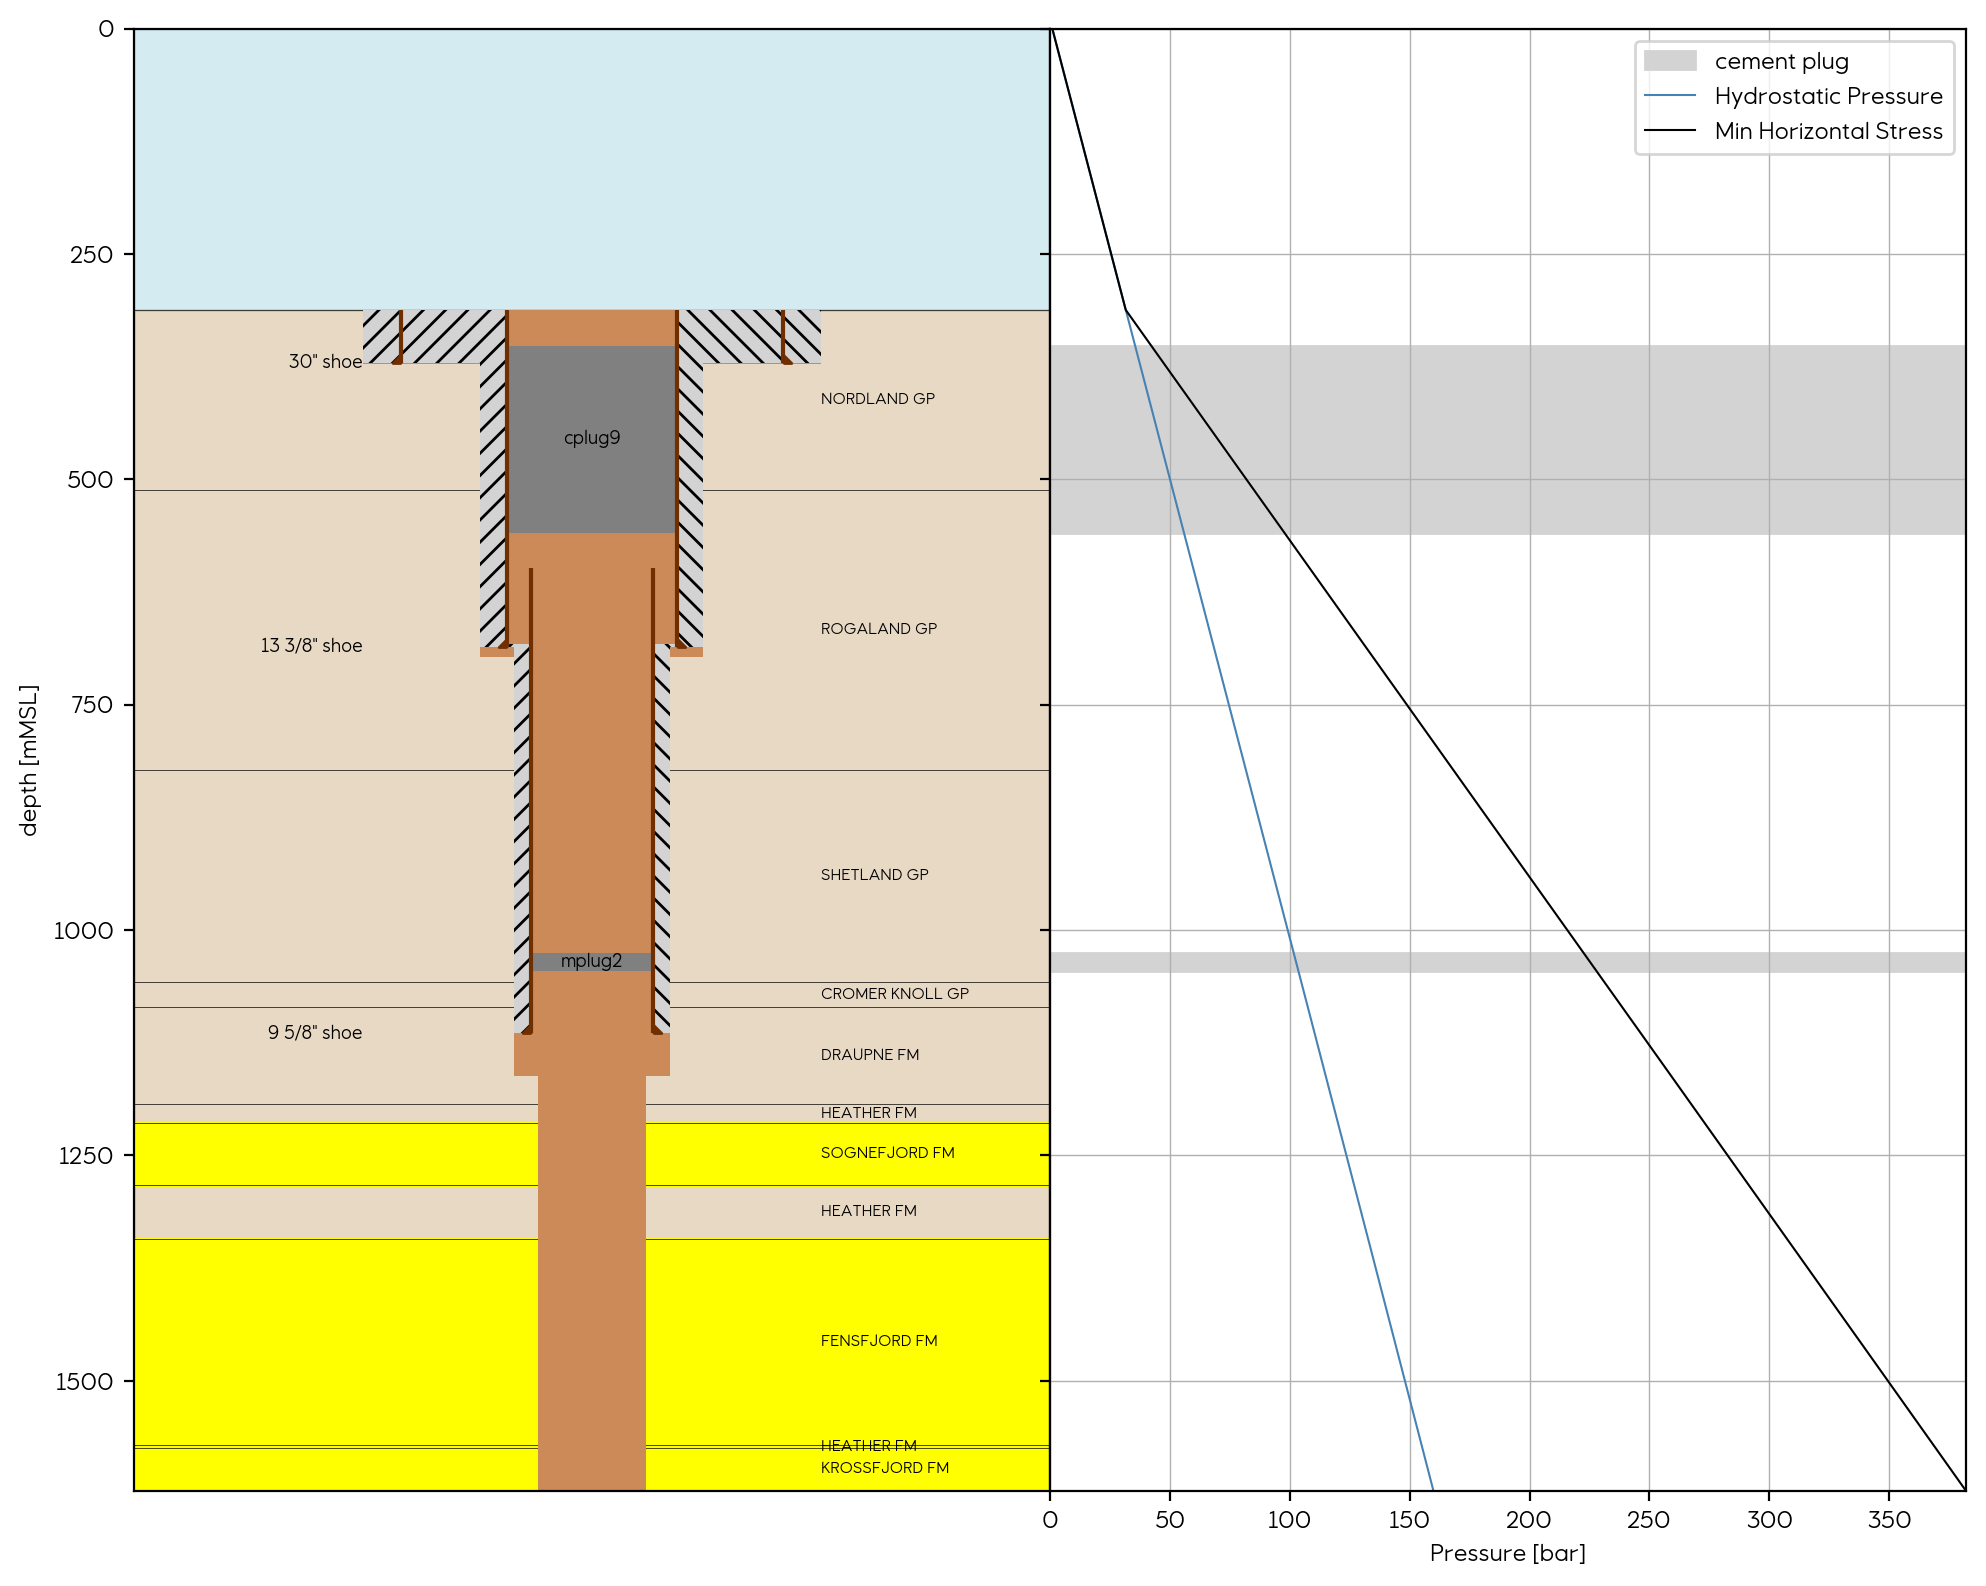

In [19]:
#Plot sketch, pressures
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(10, 8))
plot_sketch(my_well, draw_open_hole=False, ax=ax1)
plot_pressure(my_pressure, my_well.geology, my_well.barriers, ax=ax2, 
            #   plot_HSP=True, #plot brine hydrostatic gradient
              plot_MSAD= True, #plot minimum safety abandonment depth
              )


fig.tight_layout()
fig.subplots_adjust(wspace=0)

If depth of fluid contact is provided, by default Pressure class will calculate a pressure scenario with a hydrosatic gradient from the fluid contact to the surface

In [52]:
my_pressure = Pressure(sf_depth_msl=well_csv['well_header']['sf_depth_msl'],
                       well_td_rkb=well_csv['well_header']['well_td_rkb'],
                       well_rkb=well_csv['well_header']['well_rkb'],
                       sf_temp=well_csv['well_header']['sf_temp'],
                       geo_tgrad=well_csv['well_header']['geo_tgrad'],
                       fluid_type='pure_co2',
                       z_fluid_contact=well_csv['co2_datum'],
                       pvt_path='../src/WellClass/libs/pvt/pvt_constants')

Computing pressure profile for scenario: hydrostatic


[1621.5, 1282.5]


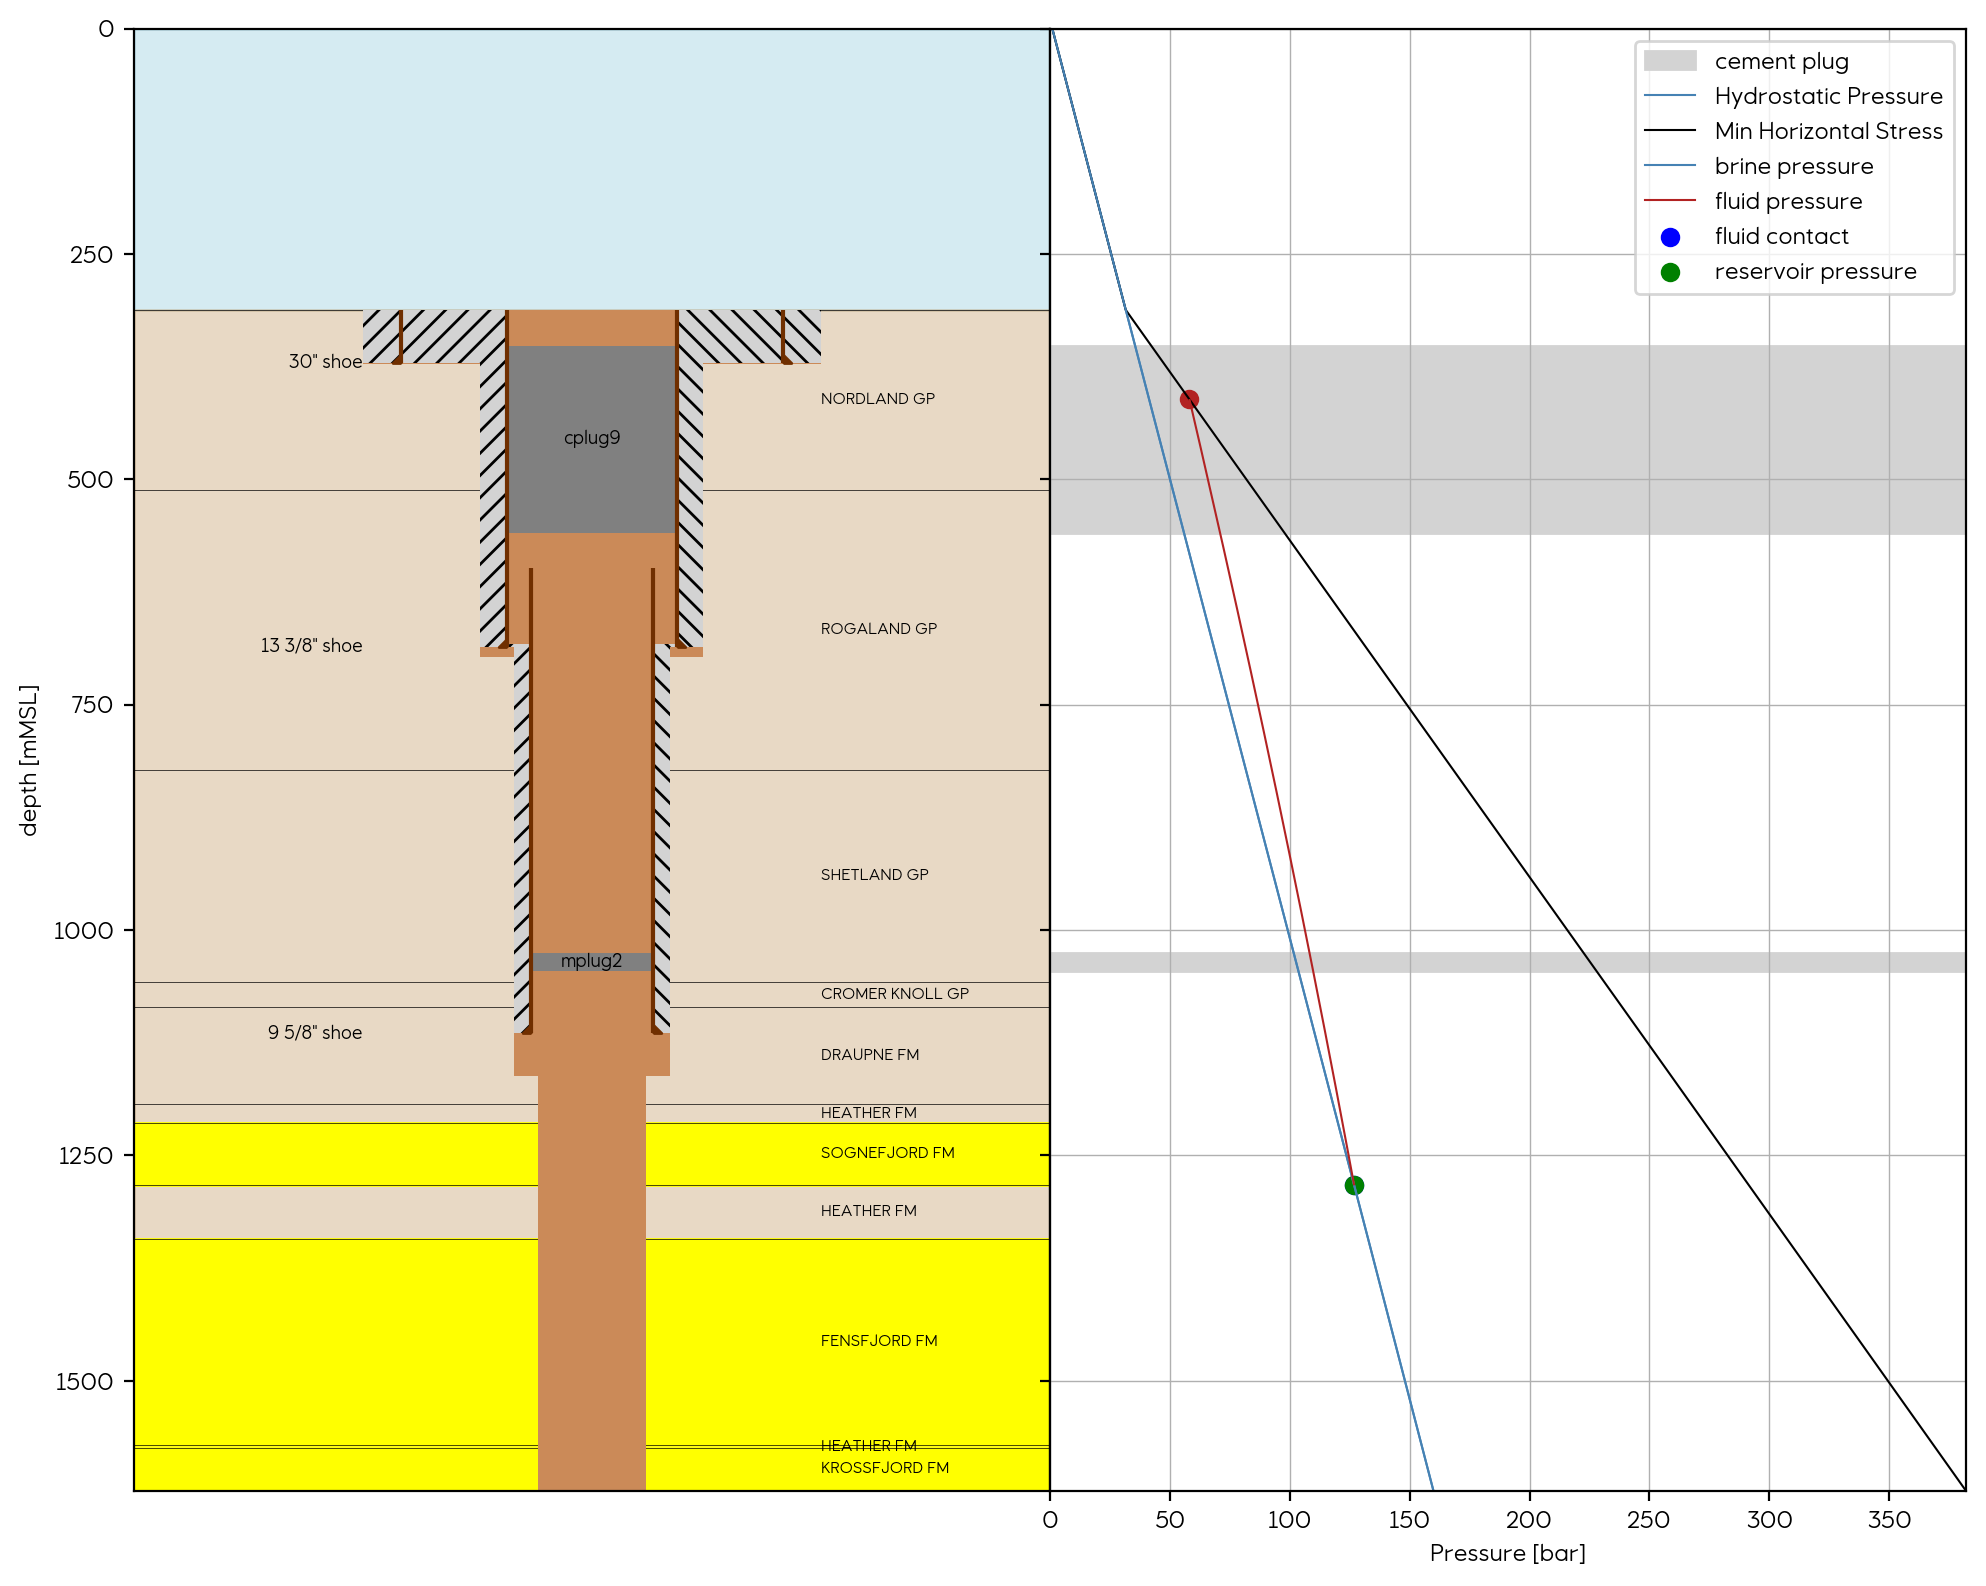

In [53]:
#Plot sketch, pressures
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(10, 8))
plot_sketch(my_well, draw_open_hole=False, ax=ax1)
plot_pressure(my_pressure, my_well.geology, my_well.barriers, ax=ax2, 
            #   plot_HSP=True, #plot brine hydrostatic gradient
              plot_RP=True, #plot reservoir pressure scenarios
              plot_MSAD= True, #plot minimum safety abandonment depth
              plot_maxP=True #plot max expected pressures
              )


fig.tight_layout()
fig.subplots_adjust(wspace=0)

If simple input scenarios are provided in the input_scenarios argument, these will be computed

In [54]:


my_pressure = Pressure(sf_depth_msl=well_csv['well_header']['sf_depth_msl'],
                       well_td_rkb=well_csv['well_header']['well_td_rkb'],
                       well_rkb=well_csv['well_header']['well_rkb'],
                       sf_temp=well_csv['well_header']['sf_temp'],
                       geo_tgrad=well_csv['well_header']['geo_tgrad'],
                       fluid_type='pure_co2',
                       input_scenarios=well_csv['reservoir_pressure'],
                       z_fluid_contact=well_csv['co2_datum'],
                       pvt_path='../src/WellClass/libs/pvt/pvt_constants')

Computing pressure profile for scenario: RP1
Computing pressure profile for scenario: RP2
Computing pressure profile for scenario: RP3


[1621.5, 1282.5]


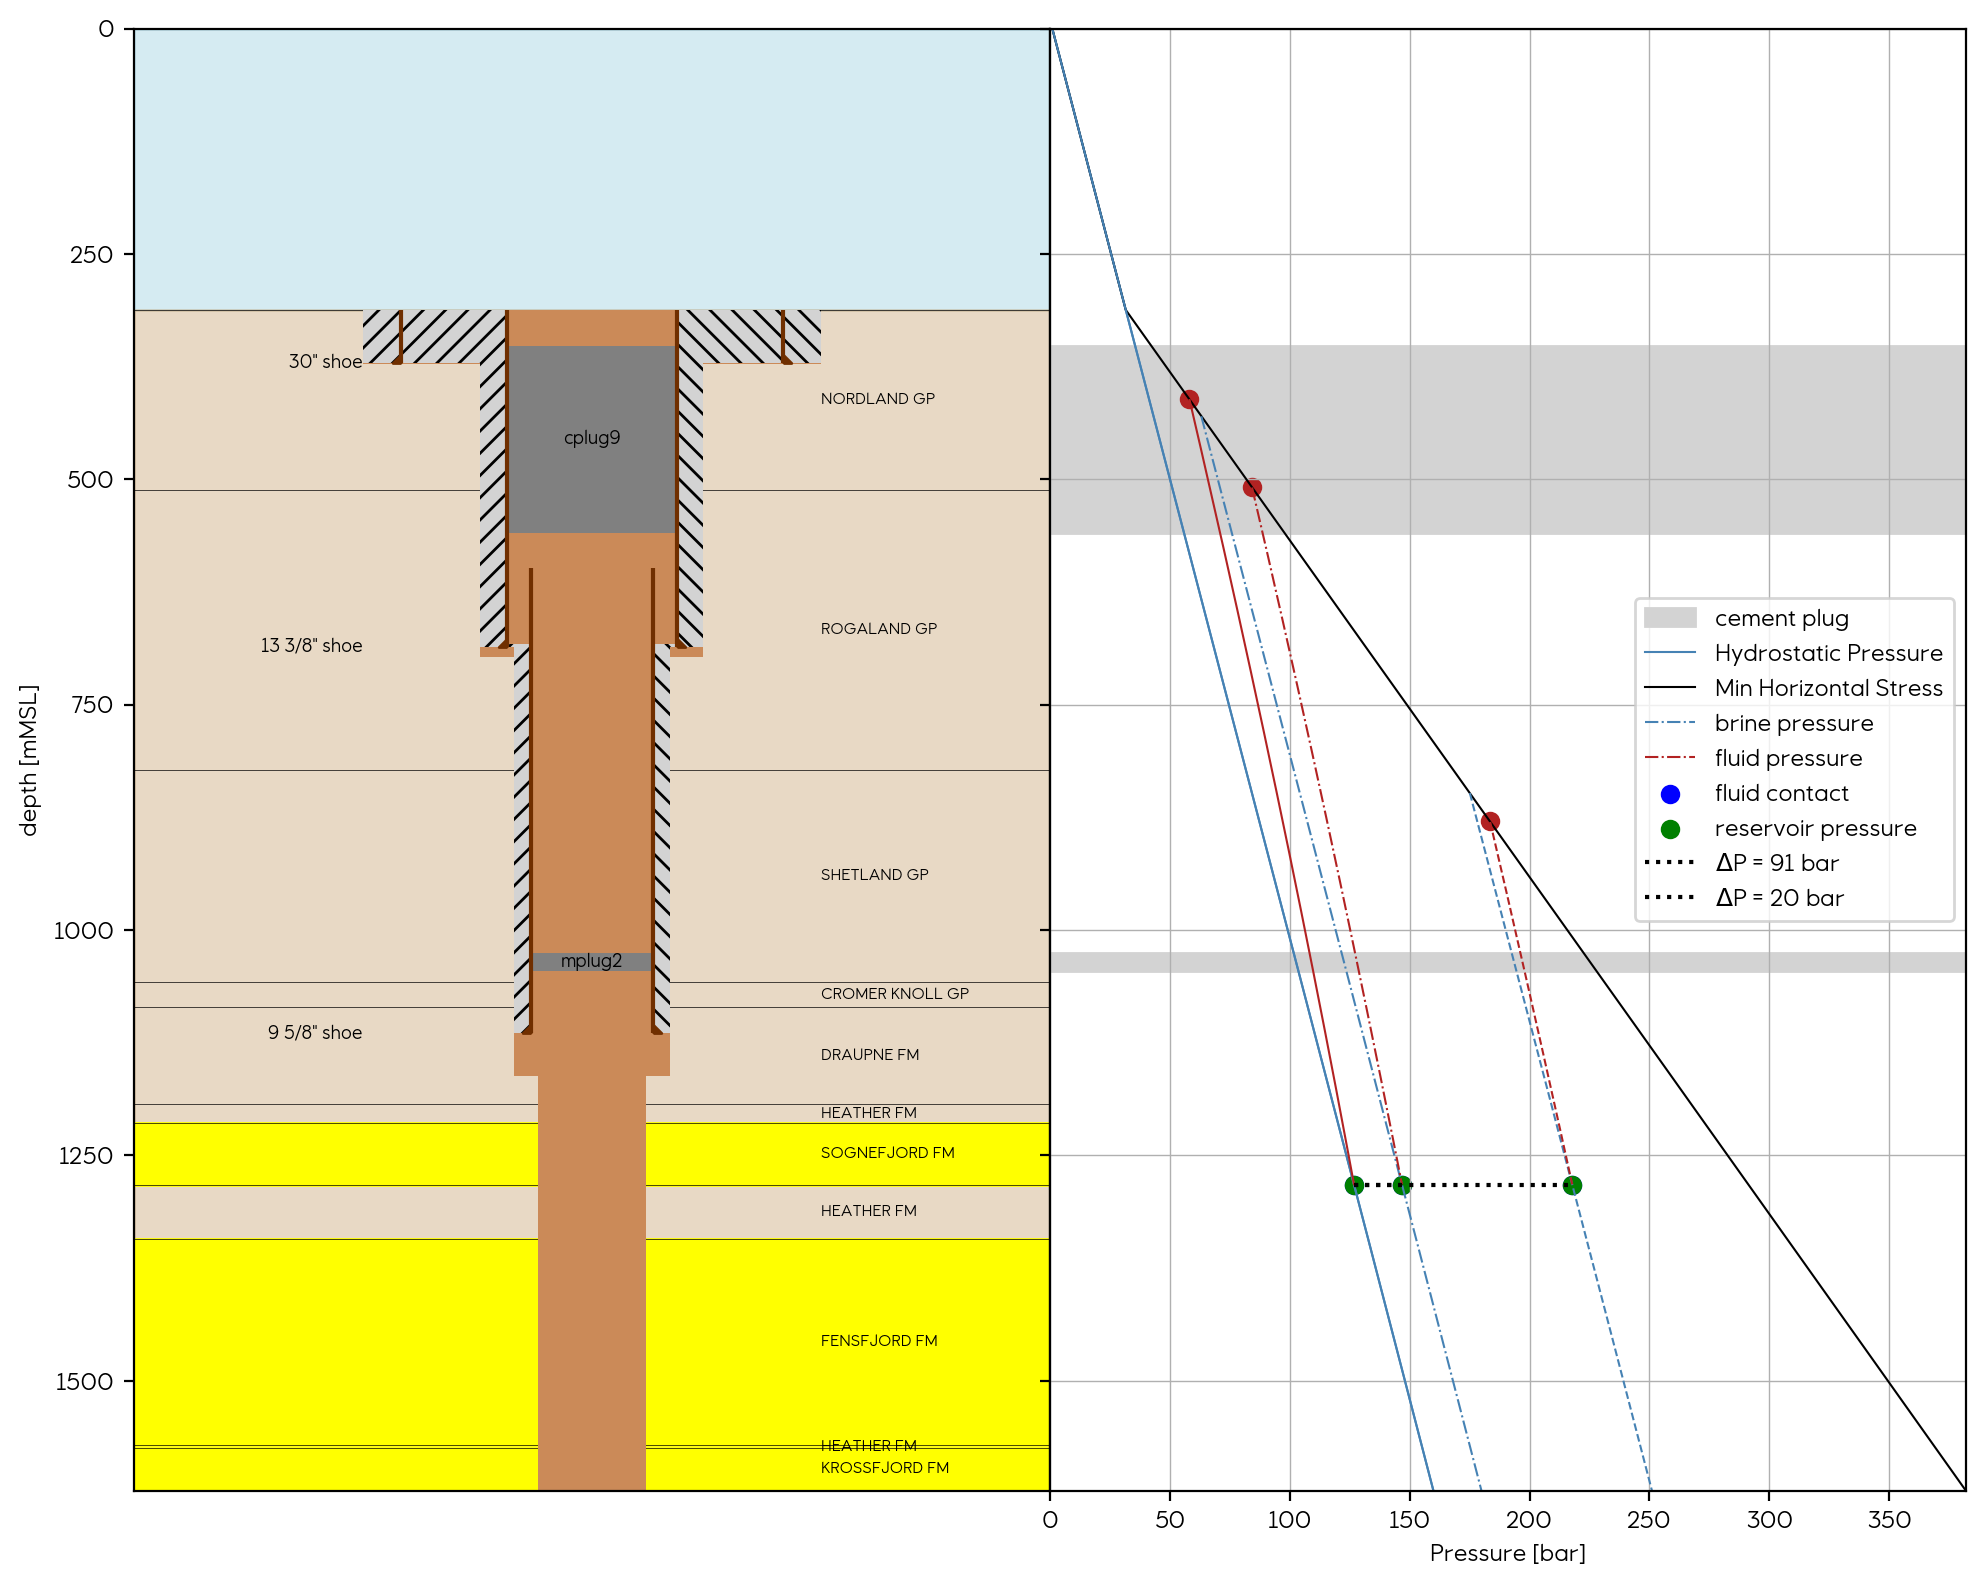

In [55]:
#Plot sketch, pressures
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(10, 8))
plot_sketch(my_well, draw_open_hole=False, ax=ax1)
plot_pressure(my_pressure, my_well.geology, my_well.barriers, ax=ax2, 
            #   plot_HSP=True, #plot brine hydrostatic gradient
              plot_RP=True, #plot reservoir pressure scenarios
              plot_MSAD= True, #plot minimum safety abandonment depth
              plot_maxP=True #plot max expected pressures
              )


fig.tight_layout()
fig.subplots_adjust(wspace=0)

In [56]:
my_pressure.scenario_manager.get_scenarios_summary()

,name,from_resrvr,z_MSAD,p_MSAD,z_resrv,p_resrv,z_fluid_contact,p_fluid_contact,p_delta
0,RP1,True,411.240043,58.200635,1282.5,126.834373,1282.5,126.834373,0.0
1,RP2,True,879.396770,183.528345,1282.5,217.834373,1282.5,217.834373,91.0
2,RP3,True,508.572015,84.259941,1282.5,146.834373,1282.5,146.834373,20.0


In [57]:
my_pressure.add_scenario(scenario_name='plug', from_resrvr=False, z_MSAD = 680, z_fluid_contact = 1500)

Computing pressure profile for scenario: plug


[1621.5, 1282.5]


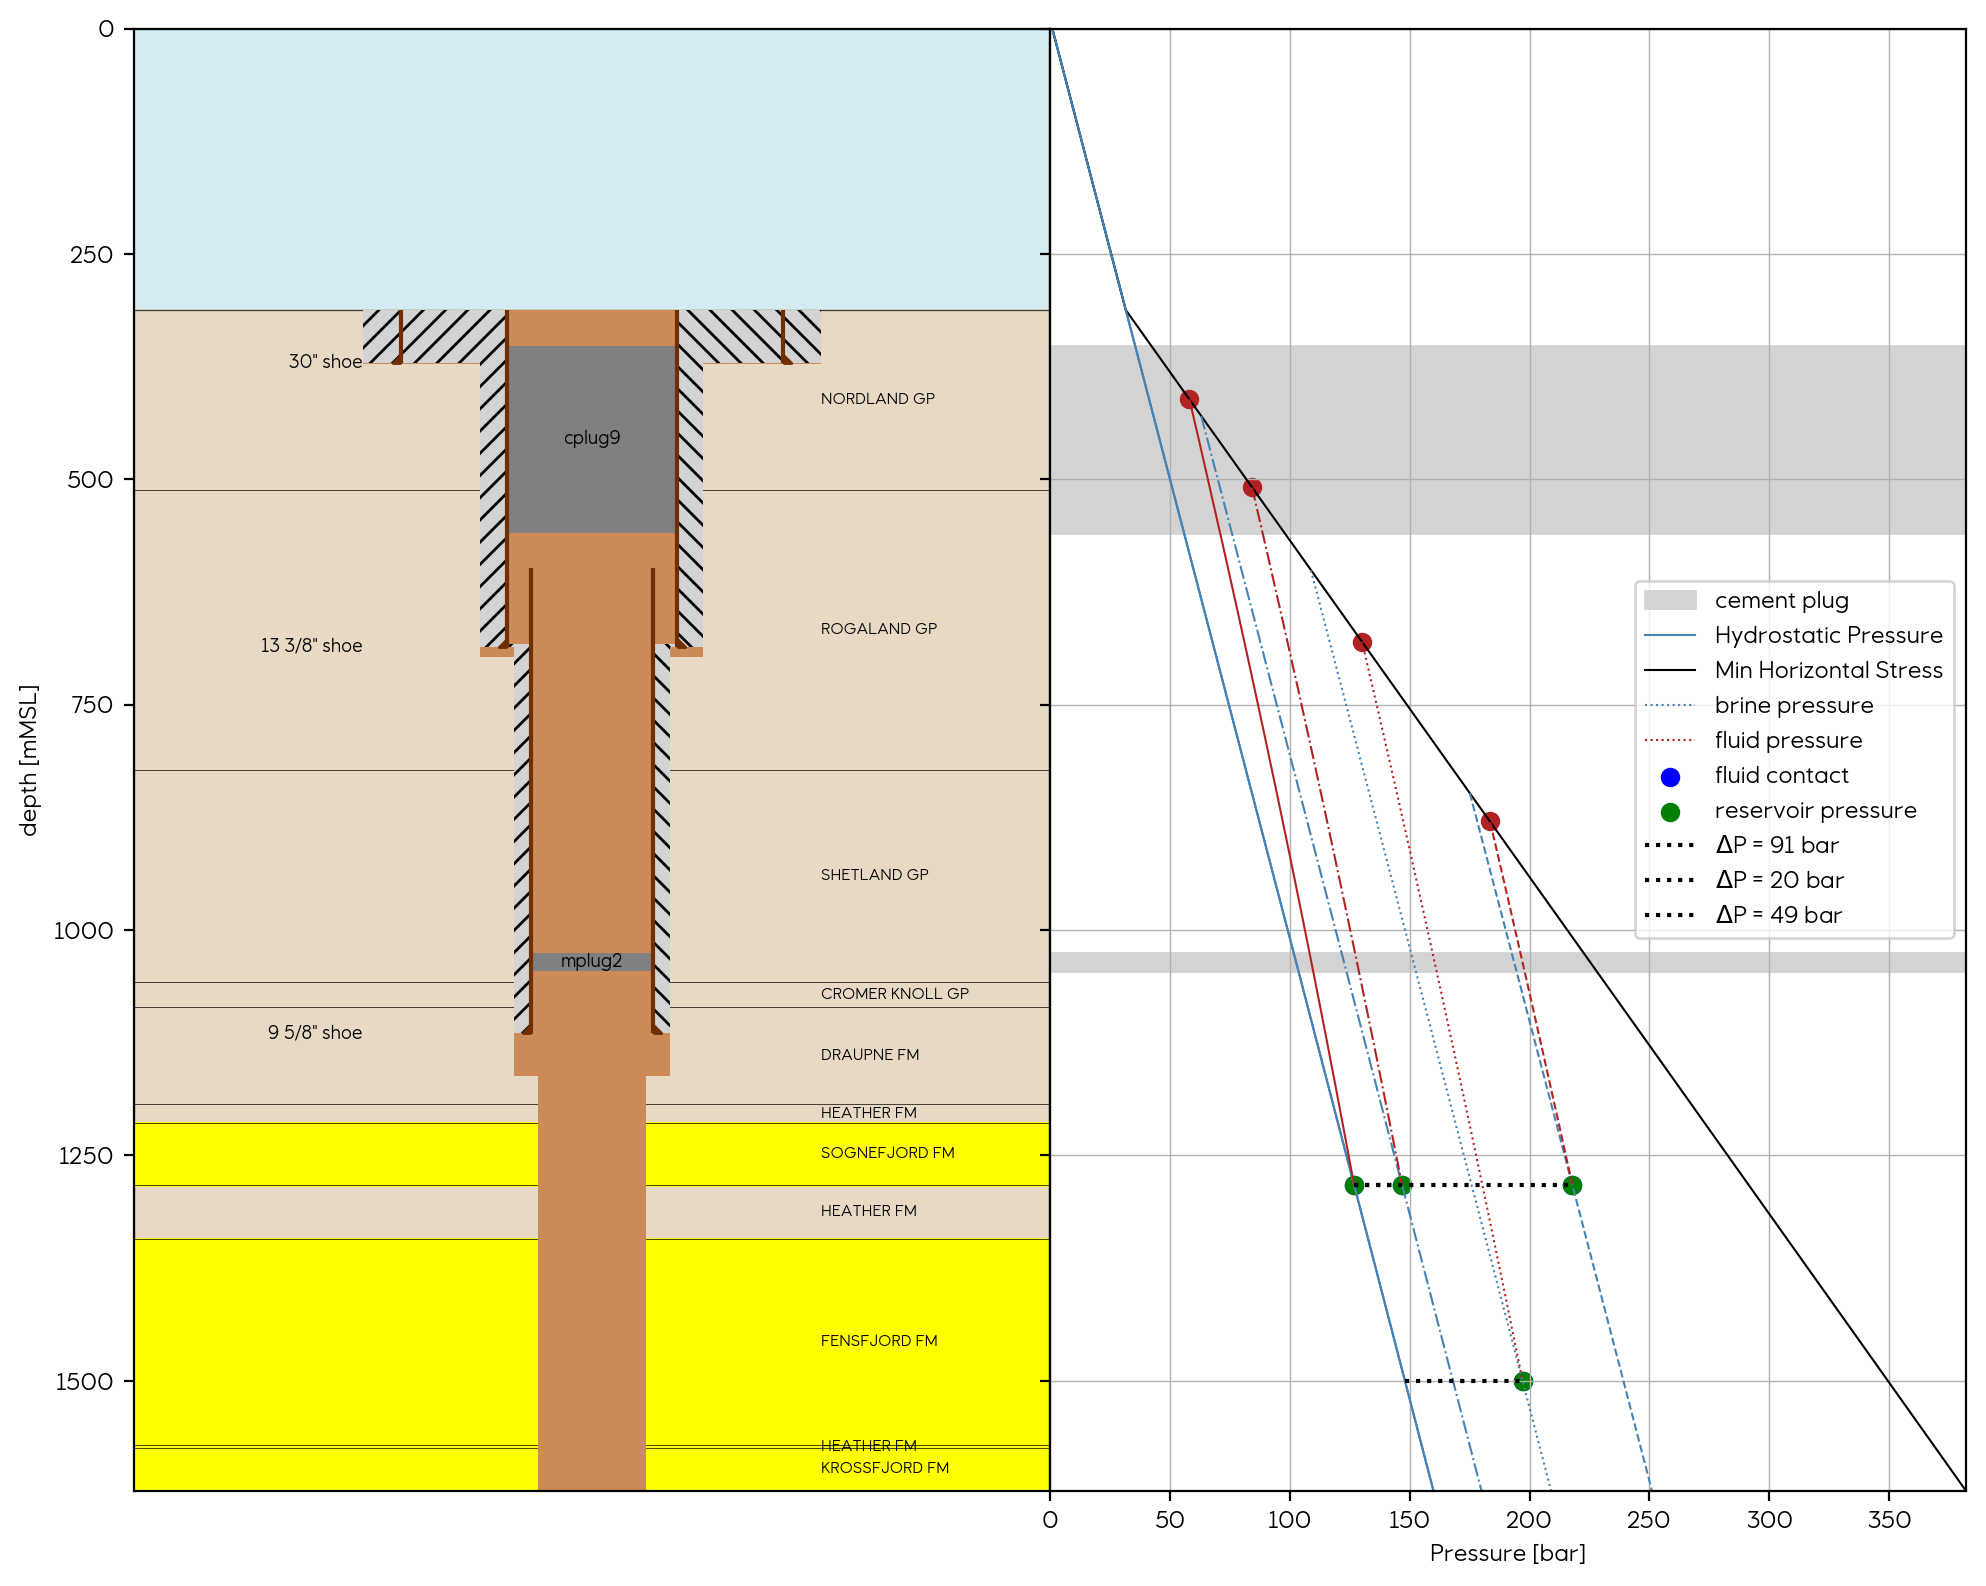

In [58]:
#Plot sketch, pressures
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(10, 8))
plot_sketch(my_well, draw_open_hole=False, ax=ax1)
plot_pressure(my_pressure, my_well.geology, my_well.barriers, ax=ax2, 
            #   plot_HSP=True, #plot brine hydrostatic gradient
              plot_RP=True, #plot reservoir pressure scenarios
              plot_MSAD= True, #plot minimum safety abandonment depth
              plot_maxP=True #plot max expected pressures
              )


fig.tight_layout()
fig.subplots_adjust(wspace=0)

In [25]:
! pip install schemdraw


<>:9: SyntaxWarning: invalid escape sequence '\D'
<>:9: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_633/1348946425.py:9: SyntaxWarning: invalid escape sequence '\D'
  flow.Box(h=4).label('Pressure scenario schema:\n- p_fluid_contact\n- z_fluid_contact\n- p_resrv\n- z_resrv\n- p_MSAD\n- z_MSAD\n- overp ($\Delta$p)').drop('S')


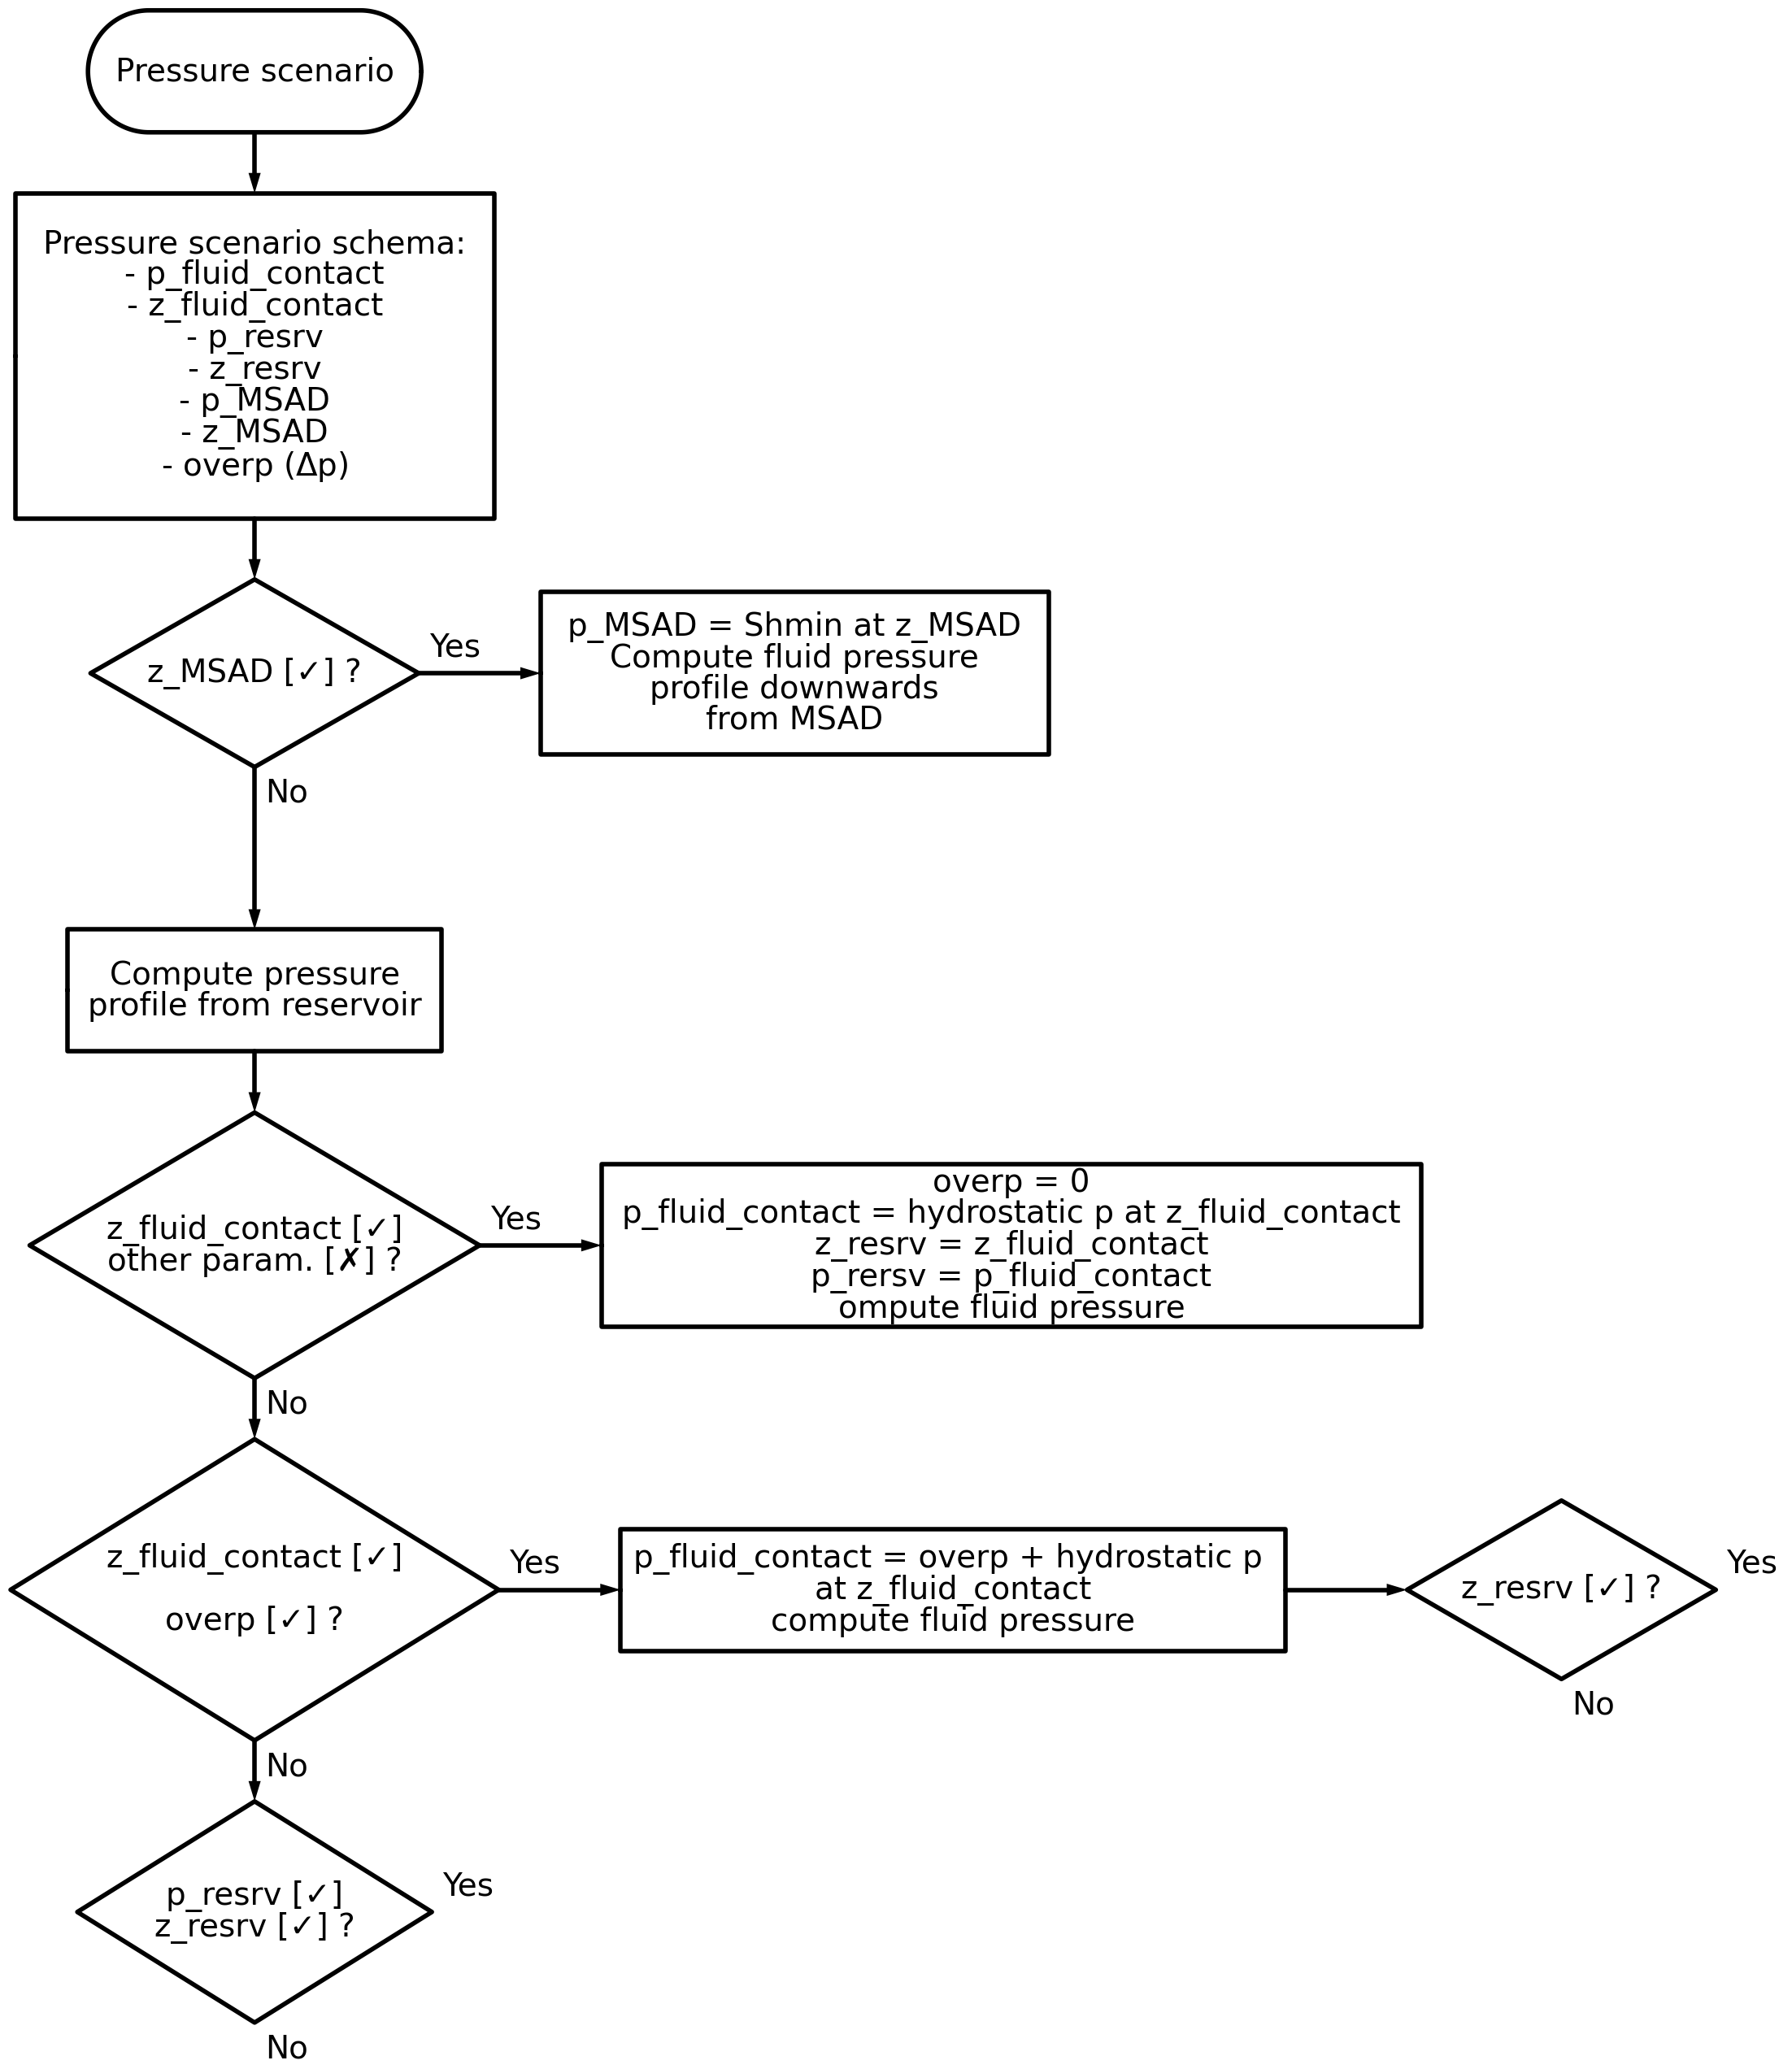

In [ ]:
import schemdraw
import schemdraw.elements as elm
import schemdraw.flow as flow

with schemdraw.Drawing() as d:
    d.config(unit=.75)
    flow.Start(h=1.5).label('Pressure scenario').drop('S')
    flow.Arrow().down()
    flow.Box(h=4).label('Pressure scenario schema:\n- p_fluid_contact\n- z_fluid_contact\n- p_resrv\n- z_resrv\n- p_MSAD\n- z_MSAD\n- overp ($\Delta$p)').drop('S')
    flow.Arrow().down()
    dA = flow.Decision(E='Yes', S='No').label('z_MSAD [\u2713] ?')
    flow.Arrow(l=2).down().at(dA.S)
    dAB = flow.Box(h=1.5).label('Compute pressure\nprofile from reservoir')
    flow.Arrow(l=1.5).right().at(dA.E)
    dAA = flow.Box(h=2).label('p_MSAD = Shmin at z_MSAD\nCompute fluid pressure\nprofile downwards\nfrom MSAD').drop('S')



    flow.Arrow().down().at(dAB.S)
    dABB = flow.Decision(E='Yes', S='No').label('z_fluid_contact [\u2713]\nother param. [\u2717] ?')
    flow.Arrow().down()
    dABBB = flow.Decision(E='Yes', S='No').label('z_fluid_contact [\u2713]\n\noverp [\u2713] ?')
    flow.Arrow().down()
    dABBBB = flow.Decision(E='Yes', S='No').label('p_resrv [\u2713]\nz_resrv [\u2713] ?')
    flow.Arrow(l=1.5).right().at(dABB.E)
    dABBA = flow.Box(h=2).label('overp = 0\np_fluid_contact = hydrostatic p at z_fluid_contact\nz_resrv = z_fluid_contact\np_rersv = p_fluid_contact\ncompute fluid pressure').drop('S')
    flow.Arrow(l=1.5).right().at(dABBB.E)
    dABBBA = flow.Box(h=1.5).label('p_fluid_contact = overp + hydrostatic p \nat z_fluid_contact\ncompute fluid pressure').drop('S')
    flow.Arrow(l=1.5).right().at(dABBBA.E)
    dABBBAA = flow.Decision(E='Yes', S='No').label('z_resrv [\u2713] ?')

    # flow.Arrow().down()
    # flow.Box(h=1.5).label('wrong combination of input').drop('S')


    # flow.Arrow(l=1.5).right().at(from_resrv.E)
    # from_MSAD = flow.Box(h=1.5).label('compute fluid pressure\nprofile downwards\nfrom MSAD').drop('S')
    # flow.Arrow().right().at(from_MSAD.E)
    # from_MSAD_fc = flow.Decision(E='Yes', S='No').label('fluid contact [\u2713] ?')
    # flow.Arrow(l=1.5).right().at(from_MSAD_fc.E)
    # from_MSAD_fc_True = flow.Box(h=1.5).label('compute brine pressure\nprofile fromfluid pressure at\nfluid contact depth').drop('S')
    # flow.Arrow(l=1.5).down().at(from_MSAD_fc.S)
    # from_MSAD_fc_False = flow.Box(h=2).label('Assume overp = 0.\nz_fluid_contact, p_fluid_contact = intersection between\nfluid pressure and hydrostatic gradients').drop('S')

    # flow.Arrow(l=1.5).right().at(fluid_contact.E)
    # fluid_contact_True = flow.Box(h=2.0).label('Assume overpressure  = 0.\nBrine pressure profile = hydrostatic\nCompute fluid pressure profile from \n brine pressure at fluid contact depth').drop('S')


    # flow.Arrow(l=1.5).right().at(fluid_contact_ovp.E)
    # from_r = flow.Decision(E='Yes', S='No').label('reservoir pressure [\u2713] ?')
    # flow.Arrow(l=1.5).right().at(from_r.E)
    # from_rr = flow.Decision(E='Yes', S='No').label('z (reservoir)\n<\nz (fluid contact)?')
    # flow.Arrow(l=1.5).right().at(from_rr.E)
    # from_rr_True = flow.Box(h=1.5).label('interpolate reservoir pressure\nfrom ').drop('S')
    # fluid_contact_ovp_True = flow.Box(h=1.5).label('Compute profiles from \np (fluid contact) + $\Delta$p').drop('S')

    # flow.Box().label('Add final\nelement\nto dictionary').drop('S')
    # flow.Arrow().down()
    # flow.Start().label('Stop')
    # flow.Arrow().at(k2.S)
    # kn = flow.Decision(W='No', S='Yes').label('Is $k$ a\nfactor of $n$?').drop('W')
    # flow.Arrow().left().length(1)
    # flow.Box().label('Replace $k$\nby $k+1$').drop('N')
    # flow.Arrow().toy(k2.W).dot(open=True)
    # flow.Arrow().tox(k2.W)

    # flow.Arrow().down().at(kn.S)
    # flow.Box().label('Replace $n$\nby $n/k$')
    # flow.Arrow()
    # k3 = flow.Decision(E='No', W='Yes').label('Is $k$ in\ndictionary?').drop('E')

    # flow.Arrow().left().at(k3.W).length(1)
    # rep = flow.Box().label('Replace $v$\nby $v+1$')
    # flow.Arrow()
    # dot = flow.Arrow().up().toy(k2.W).dot(open=True)
    # flow.Arrow().right().tox(rep.N)

    # flow.Arrow().at(k3.E).right().length(1)
    # flow.Box().label('Add $k$ to\ndictionary\nwith $v=1$').drop('S')
    # flow.Arrow().down()
    # flow.Arrow().left().to(rep.W, dx=-1.5)
    # flow.Arrow().up().toy(k2.W)
    # flow.Arrow().right().tox(dot.center)

### 2. Create a pressure scenario

Create a pressure scenario providing only the **MSAD** (the `from_resrv` flag has to be False )

In [59]:
my_pressure = Pressure(sf_depth_msl=well_csv['well_header']['sf_depth_msl'],
                       well_td_rkb=well_csv['well_header']['well_td_rkb'],
                       well_rkb=well_csv['well_header']['well_rkb'],
                       sf_temp=well_csv['well_header']['sf_temp'],
                       geo_tgrad=well_csv['well_header']['geo_tgrad'],
                       fluid_type='pure_co2',
                       pvt_path='../src/WellClass/libs/pvt/pvt_constants')

my_pressure.add_scenario(scenario_name='plug', from_resrvr=False, z_MSAD = 680, z_fluid_contact = 1500)

my_pressure.scenario_manager.get_scenarios_summary()

Computing pressure profile for scenario: plug


,name,from_resrvr,z_MSAD,p_MSAD,z_resrv,p_resrv,z_fluid_contact,p_fluid_contact,p_delta
0,plug,False,680,130.156159,1500,197.097666,1500,197.097666,49.037993


Create a pressure scenario providing only the **delta Pressure +/-** and depth **fluid_contact**. The code assumes the reservoir depth is the same as the `co2_datum` (the `from_resrv` flag has to be True )

In [65]:
my_pressure = Pressure(sf_depth_msl=well_csv['well_header']['sf_depth_msl'],
                       well_td_rkb=well_csv['well_header']['well_td_rkb'],
                       well_rkb=well_csv['well_header']['well_rkb'],
                       sf_temp=well_csv['well_header']['sf_temp'],
                       geo_tgrad=well_csv['well_header']['geo_tgrad'],
                       fluid_type='pure_co2',
                       z_fluid_contact=1200,
                       pvt_path='../src/WellClass/libs/pvt/pvt_constants')

my_pressure.add_scenario(scenario_name='plug', from_resrvr=True, p_delta = 50, z_fluid_contact = 1300)

# my_pressure.create_pressure_scenario(name='test2', from_resrvr=True, p_delta=50)
# pd.DataFrame(my_pressure.pressure_scenarios).T

Computing pressure profile for scenario: hydrostatic
Computing pressure profile for scenario: plug


In [66]:
my_pressure.scenario_manager.get_scenarios_summary()

,name,from_resrvr,z_MSAD,p_MSAD,z_resrv,p_resrv,z_fluid_contact,p_fluid_contact,p_delta
0,hydrostatic,True,400.272722,55.264348,1200,118.767791,1200,118.767791,0
1,plug,True,663.686034,125.788695,1300,178.544413,1300,178.544413,50


[1621.5]


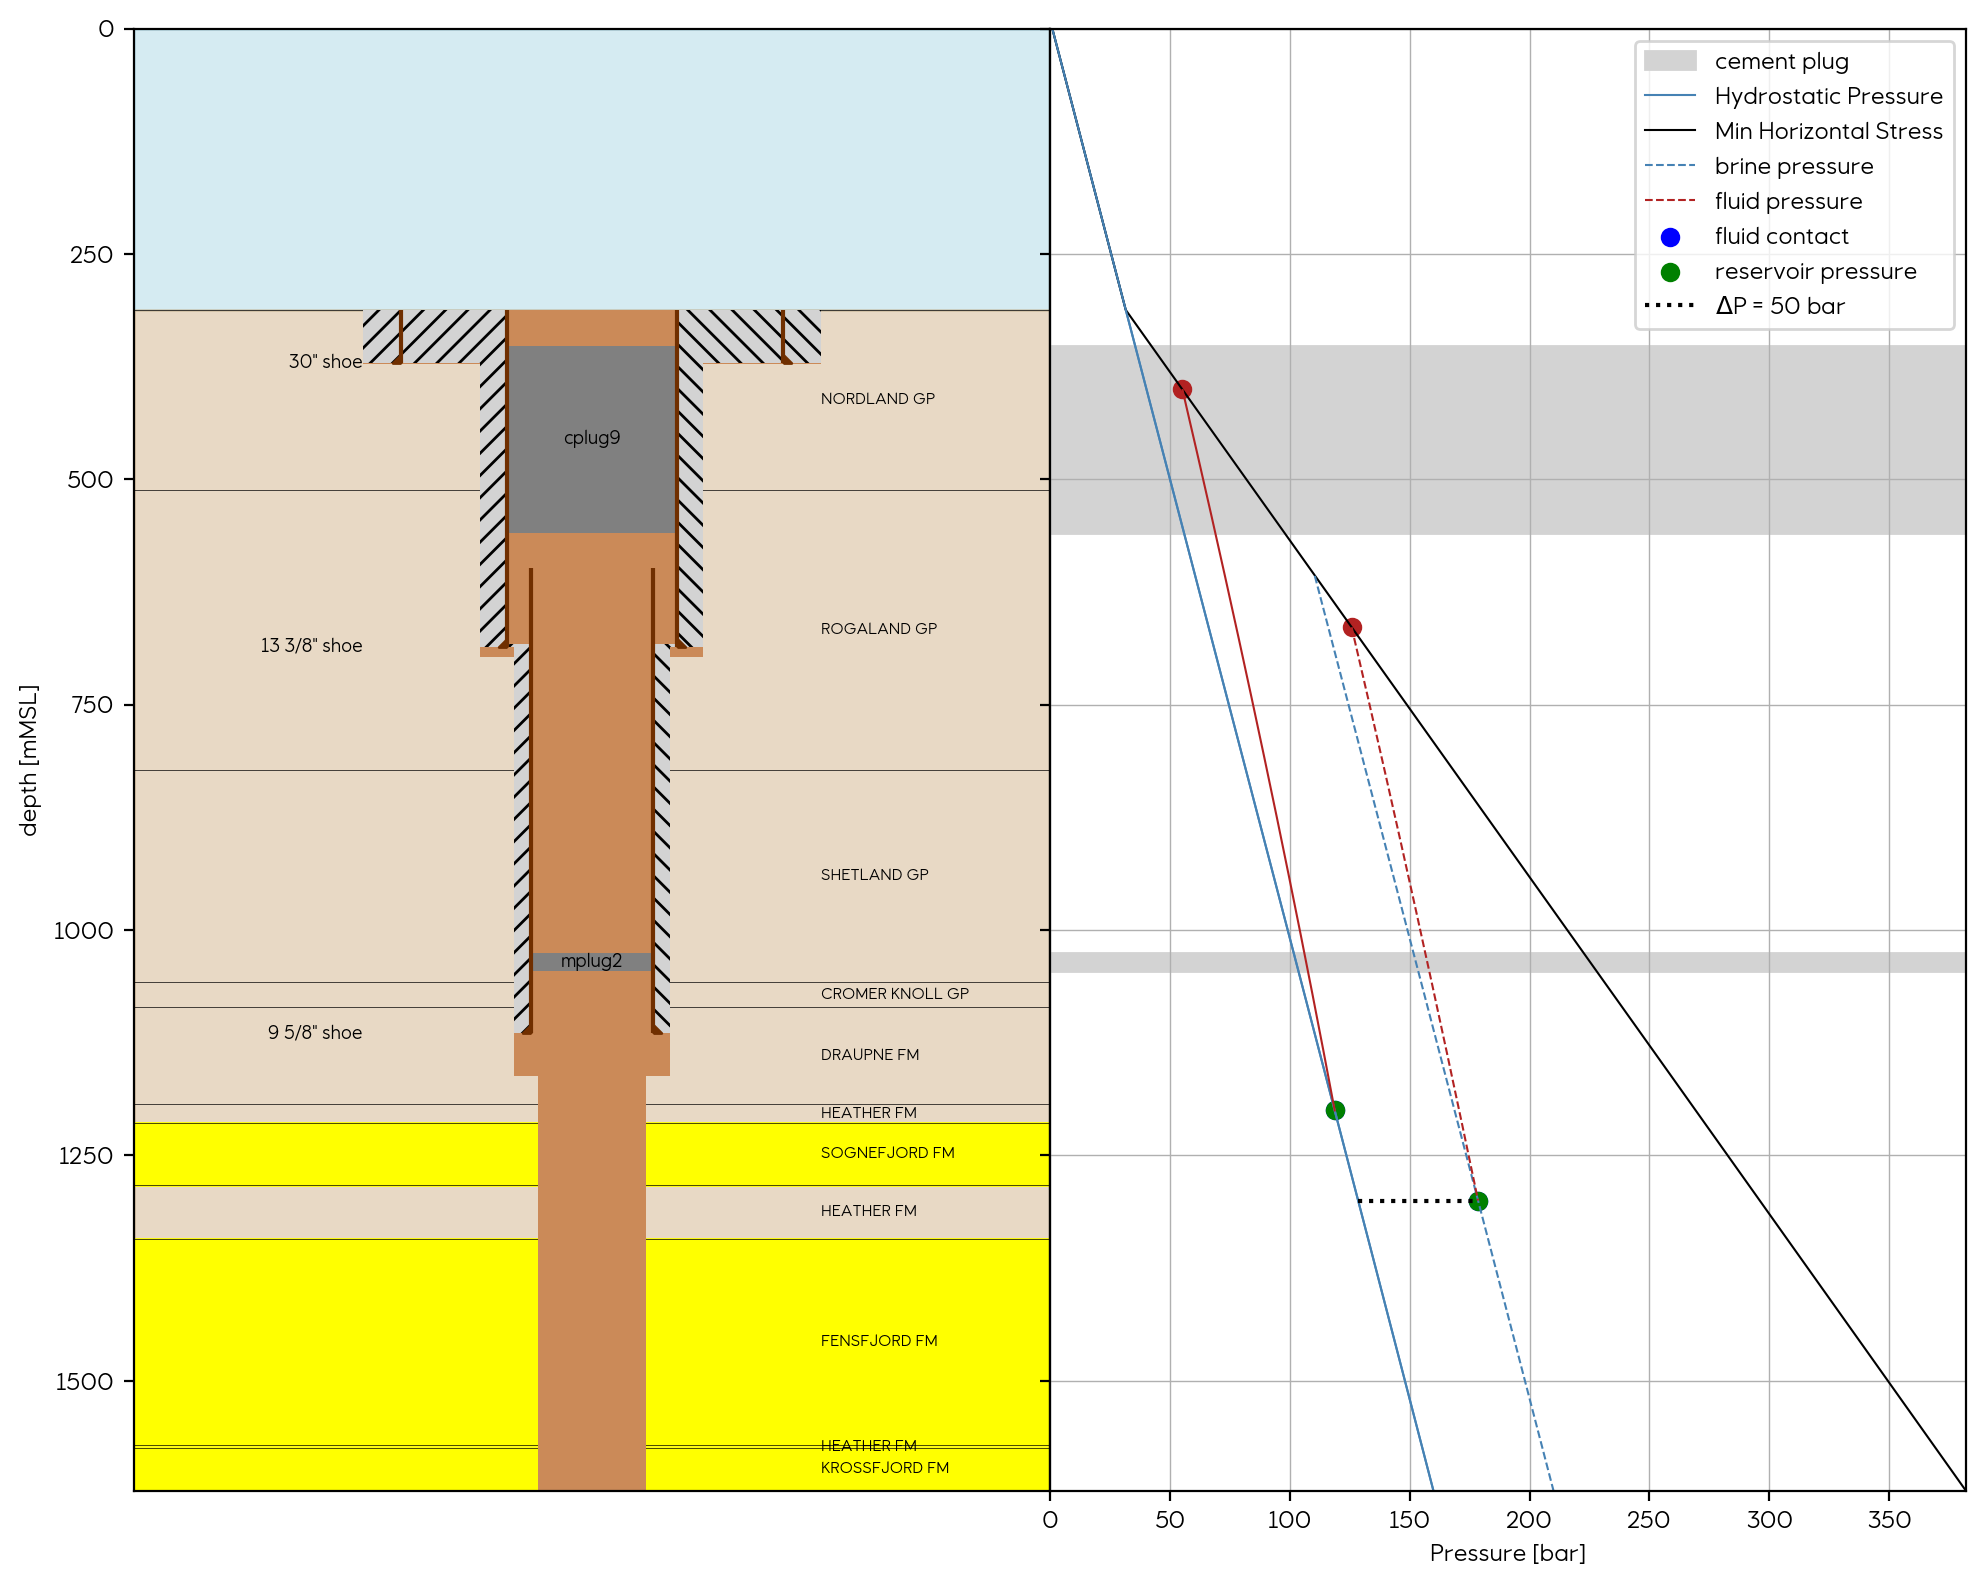

In [67]:
#Plot sketch, pressures
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(10, 8))
plot_sketch(my_well, draw_open_hole=False, ax=ax1)
plot_pressure(my_pressure, my_well.geology, my_well.barriers, ax=ax2, 
            #   plot_HSP=True, #plot brine hydrostatic gradient
              plot_RP=True, #plot reservoir pressure scenarios
              plot_MSAD= True, #plot minimum safety abandonment depth
              plot_maxP=True #plot max expected pressures
              )


fig.tight_layout()
fig.subplots_adjust(wspace=0)

Create a pressure scenario providing only the **delta Pressure +/-** at reservoir and the reservoir depth (the `from_resrv` flag has to be True )

In [210]:
my_pressure.create_pressure_scenario(name='my_sc', from_resrvr=True, p_delta=10, z_resrv=1500)

pd.DataFrame(my_pressure.pressure_scenarios).T


input parameters:
12
Pressure scenario my_sc has name = my_sc
Pressure scenario my_sc has from_resrvr = True
Pressure scenario my_sc has z_MSAD = None
Pressure scenario my_sc has p_MSAD = None
Pressure scenario my_sc has z_resrv = 1500
Pressure scenario my_sc has p_resrv = None
Pressure scenario my_sc has z_fluid_contact = 1282.5
Pressure scenario my_sc has p_fluid_contact = None
Pressure scenario my_sc has p_delta = 10

TESTING z_resrv=1500 z_fluid_contact=None

input parameters_v2:
Pressure scenario my_sc has name = my_sc
Pressure scenario my_sc has from_resrvr = True
Pressure scenario my_sc has z_MSAD = None
Pressure scenario my_sc has p_MSAD = None
Pressure scenario my_sc has z_resrv = 1500
Pressure scenario my_sc has p_resrv = 139.99502221055212
Pressure scenario my_sc has z_fluid_contact = 1500
Pressure scenario my_sc has p_fluid_contact = None
Pressure scenario my_sc has p_delta = 10

Pressure scenario my_sc: Compute pressures assuming reservoir pressure is 140.00 bar at 1500.0

,name,from_resrvr,z_MSAD,p_MSAD,z_resrv,p_resrv,z_fluid_contact,p_fluid_contact,p_delta
0,hydrostatic,True,551.915007,73.087402,1282.5,129.995022,1282.5,129.995022,0.0
1,test1,False,700,98.187808,1282.5,144.051052,1282.5,144.051052,14.056029
2,my_sc,True,None,None,1500,None,1282.5,None,10
3,my_sc,True,None,None,1500,None,None,None,10
4,my_sc,True,None,None,1500,None,None,None,10
5,my_sc,True,None,None,1500,None,None,None,10
6,my_sc,True,None,None,1500,None,1282.5,None,10
7,my_sc,True,None,None,1500,None,1282.5,None,10
8,my_sc,True,None,None,1500,None,None,None,10
9,my_sc,True,None,None,1500,None,None,None,10


/workspaces/WINC_OnePager/notebooks/../src/WellClass/libs/plotting/plot_pressure.py:113: PerformanceWarning: indexing past lexsort depth may impact performance.
  pt_df[pt_df[('init', 'depth_msl')]>=sf_depth].plot(x=(sc_name, 'h2o'), y=('init', 'depth_msl'), ax=ax, label = '_nolegend_', color='steelblue', legend=False, lw = 0.75, ls=ls_list[counter])
/workspaces/WINC_OnePager/notebooks/../src/WellClass/libs/plotting/plot_pressure.py:113: PerformanceWarning: indexing past lexsort depth may impact performance.
  pt_df[pt_df[('init', 'depth_msl')]>=sf_depth].plot(x=(sc_name, 'h2o'), y=('init', 'depth_msl'), ax=ax, label = '_nolegend_', color='steelblue', legend=False, lw = 0.75, ls=ls_list[counter])


ValueError: x must be a label or position

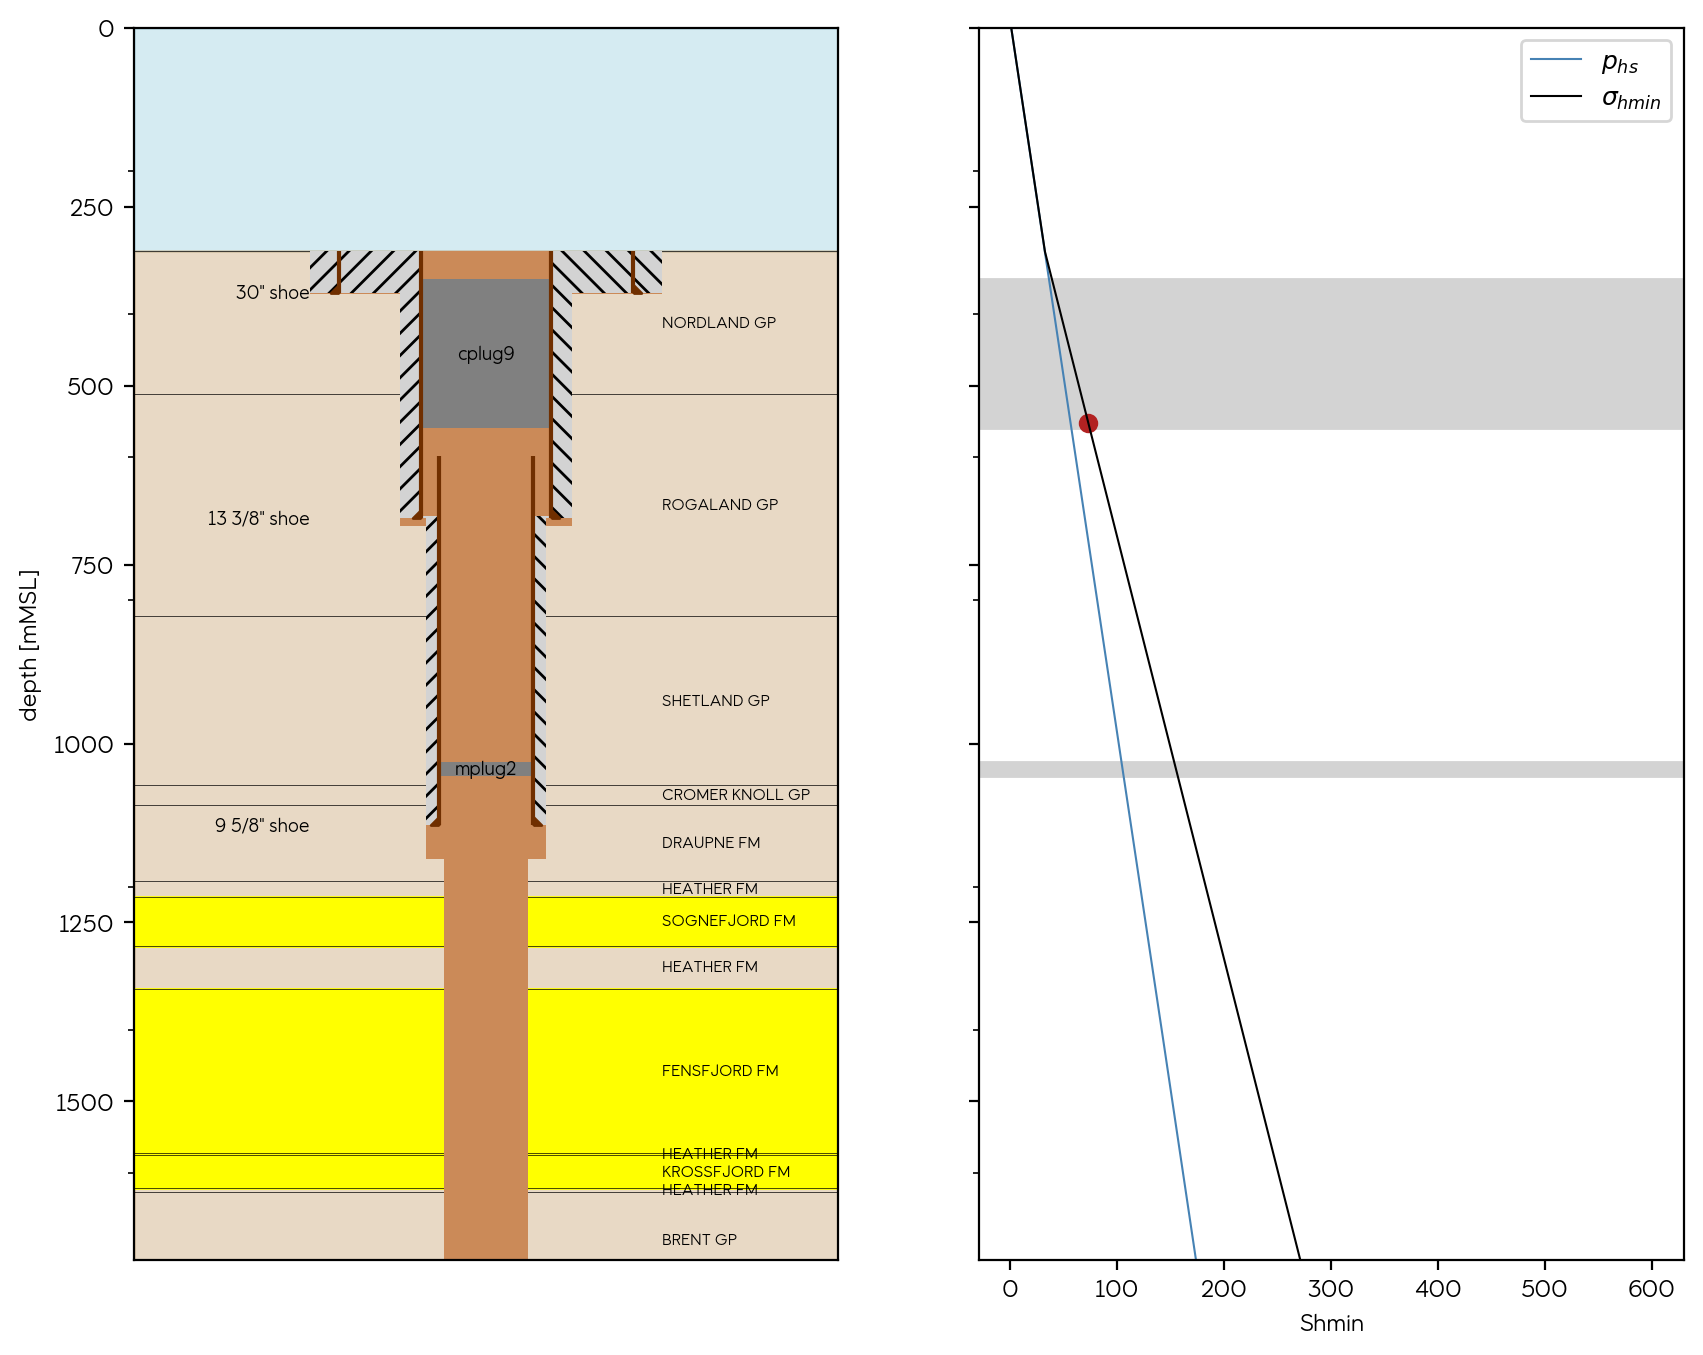

In [211]:
#Plot sketch, pressures
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(10, 8))
plot_sketch(my_well, draw_open_hole=False, ax=ax1)
plot_pressure(my_pressure, my_well.geology, my_well.barriers, ax=ax2, 
            #   plot_HSP=True, #plot brine hydrostatic gradient
              plot_RP=True, #plot reservoir pressure scenarios
              plot_MSAD= True, #plot minimum safety abandonment depth
              plot_maxP=True #plot max expected pressures
              )

ax2.scatter(161.73, 1500)
# ax2.scatter(139.99502221055212, 1100)


fig.tight_layout()
fig.subplots_adjust(wspace=0)

Create a pressure scenario providing a pressure measurement (value) and its correspoinding depth (the `from_resrv` flag has to be True )

In [ ]:
my_pressure.create_pressure_scenario(name='test4', from_resrvr=True, z_resrv=1500, p_resrv=260)
pd.DataFrame(my_pressure.pressure_scenarios).T

Pressure scenario test4: Compute pressures assuming reservoir pressure is 260.00 bar at 1500.00 mTVDMSL
reference_pressure=260, reference_depth=1500
self.p_resrv=260
CO2 datum pressure: nan bar at 1500.00 mTVDMSL
CO2 reference pressure: 260.00 bar at 1500.00 mTVDMSL
reference_pressure=np.float64(nan), reference_depth=1500


ValueError: All components of the initial state `y0` must be finite.

In [ ]:
my_pressure.pressure_CO2[]

init                                 hydrostatic                  \
     depth_msl    temp        hs_p       Shmin         h2o co2     co2_rho   
0            0    4.00    1.013250    1.013250    1.013250 NaN   31.384563   
1            1    4.00    1.113844    1.113844    1.113844 NaN   30.928689   
2            2    4.00    1.214438    1.214438    1.214438 NaN   30.486683   
3            3    4.00    1.315033    1.315033    1.315033 NaN   30.058199   
4            4    4.00    1.415628    1.415628    1.415628 NaN   29.642899   
...        ...     ...         ...         ...         ...  ..         ...   
3657      3657  137.80  362.426487  599.399308  362.426487 NaN  462.785854   
3658      3658  137.84  362.521618  599.568808  362.521618 NaN  462.745891   
3659      3659  137.88  362.616745  599.738308  362.616745 NaN  462.705950   
3660      3660  137.92  362.711870  599.907808  362.711870 NaN  462.666032   
3661      3661  137.96  362.806992  600.077308  362.806992 NaN  462.626138   

                           test1              ...       test2               \
     h2o_rho_in_co2_column   co2     co2_rho  ...         h2o      h2o_rho   
0              1027.621541   NaN   20.837992  ...   50.715884  1028.251138   
1              1027.621693   NaN   20.751755  ...   50.816722  1028.256148   
2              1027.621843   NaN   20.671817  ...   50.917560  1028.261158   
3              1027.621991   NaN   20.598070  ...   51.018399  1028.266167   
4              1027.622137   NaN   20.530409  ...   51.119239  1028.271177   
...                    ...   ...         ...  ...         ...          ...   
3657            964.991899   NaN  476.216929  ...  412.928063   971.873568   
3658            964.961196   NaN  476.175078  ...  413.023369   971.841608   
3659            964.930488   NaN  476.133250  ...  413.118672   971.809643   
3660            964.899774   NaN  476.091446  ...  413.213972   971.777672   
3661            964.869054   NaN  476.049666  ...  413.309269   971.745697   

                                                 test3                   \
     co2     co2_rho h2o_rho_in_co2_column         h2o      h2o_rho co2   
0    NaN  930.249943           1029.097421   70.305849  1029.222241 NaN   
1    NaN  930.324439           1029.101936   70.406782  1029.227233 NaN   
2    NaN  930.398887           1029.106452   70.507715  1029.232225 NaN   
3    NaN  930.473287           1029.110968   70.608649  1029.237217 NaN   
4    NaN  930.547639           1029.115485   70.709583  1029.242209 NaN   
...   ..         ...                   ...         ...          ...  ..   
3657 NaN  572.613448            968.761685  432.824738   971.873568 NaN   
3658 NaN  572.561439            968.732012  432.920045   971.841608 NaN   
3659 NaN  572.509454            968.702333  433.015349   971.809643 NaN   
3660 NaN  572.457493            968.672650  433.110650   971.777672 NaN   
3661 NaN  572.405556            968.642961  433.205947   971.745697 NaN   

                                        
         co2_rho h2o_rho_in_co2_column  
0     943.779137           1029.975814  
1     943.844908           1029.980376  
2     943.910644           1029.984939  
3     943.976346           1029.989502  
4     944.042014           1029.994066  
...          ...                   ...  
3657  602.515746            970.041038  
3658  602.461896            970.011668  
3659  602.408069            969.982293  
3660  602.354266            969.952914  
3661  602.300486            969.923529  

[3662 rows x 23 columns]

In [ ]:
my_pressure.

,depth_msl,temp,hs_p,Shmin
0,0,4.00,1.013250,1.013250
1,1,4.00,1.113844,1.113844
2,2,4.00,1.214438,1.214438
3,3,4.00,1.315033,1.315033
4,4,4.00,1.415628,1.415628
...,...,...,...,...
3657,3657,137.80,362.426487,599.399308
3658,3658,137.84,362.521618,599.568808
3659,3659,137.88,362.616745,599.738308
3660,3660,137.92,362.711870,599.907808


In [26]:
pd.DataFrame(my_pressure.pressure_scenarios).T

,name,z_MSAD,from_resrvr,p_MSAD,p_resrv,z_resrv,p_delta,z_co2_datum
0,hydrostatic,551.915007,True,73.087402,129.995022,1282.5,0.0,1282.5
1,test1,600,False,81.237808,134.604586,1282.5,4.609563,1282.5
2,test2,1093.163171,True,164.828965,179.995022,1282.5,50.0,1282.5
3,test3,1313.818744,True,202.230085,301.030048,2300,70.0,1282.5
4,test4,None,True,None,260,2250,33.891187,2250
5,test4,None,True,None,260,1500,108.266038,1500


# Visualization

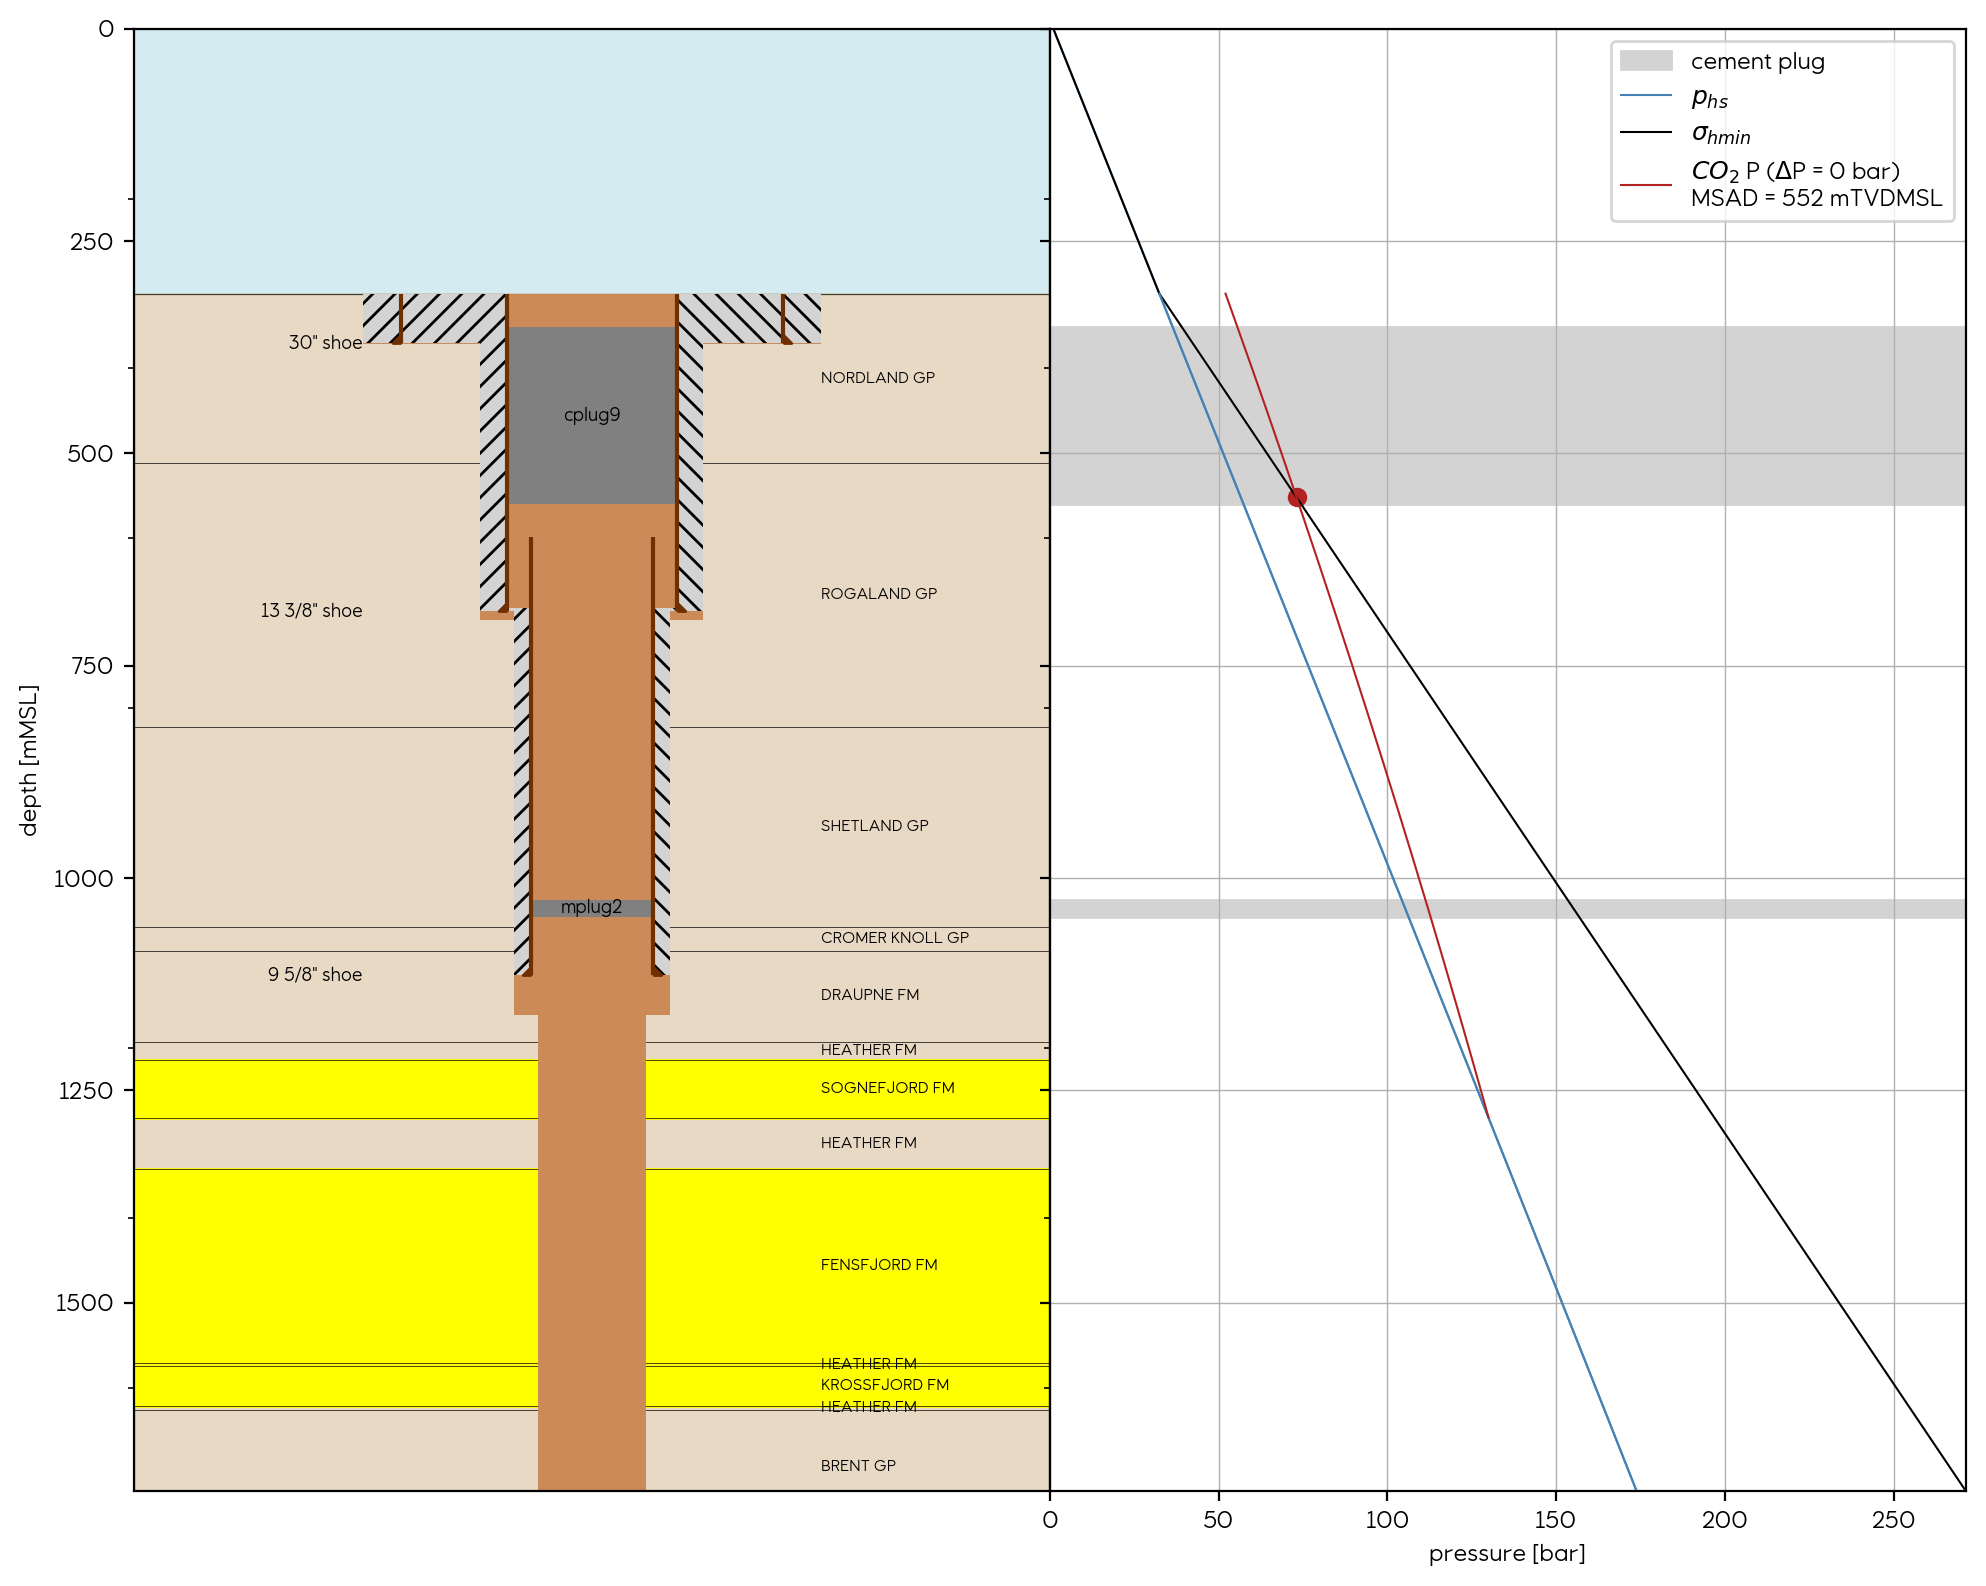

In [49]:
#Plot sketch, pressures
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(10, 8))
plot_sketch(my_well, draw_open_hole=False, ax=ax1)
plot_pressure(my_pressure, my_well.geology, my_well.barriers, ax=ax2, 
            #   plot_HSP=True, #plot brine hydrostatic gradient
              plot_RP=True, #plot reservoir pressure scenarios
              plot_MSAD= True, #plot minimum safety abandonment depth
              plot_maxP=True #plot max expected pressures
              )




fig.tight_layout()
fig.subplots_adjust(wspace=0)


## Test different fluid compositions

In [ ]:
well_csv['reservoir_pressure']['depth_msl'] = 1215.75

In [ ]:
pvt_path = '../src/WellClass/libs/pvt/pvt_constants/pure_co2'

my_pressure_pure_co2 = Pressure(
    header      = well_csv['well_header'],
    # reservoir_P = well_csv['reservoir_pressure'],
    co2_datum   = well_csv['co2_datum'],
    pvt_path    = pvt_path,
    # max_pressure_pos = 500,
    # max_pressure_pos = my_well.barriers,
)



In [ ]:
pvt_path_m1 = '../src/WellClass/libs/pvt/pvt_constants/mixture1'

my_pressure_mix1 = Pressure(
    header      = well_csv['well_header'],
    # reservoir_P = well_csv['reservoir_pressure'],
    co2_datum   = well_csv['co2_datum'],
    pvt_path    = pvt_path_m1,
    # max_pressure_pos = 500,
    # max_pressure_pos = my_well.barriers,
)

with open(pvt_path_m1 + "/metadata.json", "r") as file:
    mixture_info = json.load(file)

mixture1_name = mixture_info['name']
mixture1_composition = mixture_info['composition']


In [ ]:
pvt_path_m2 = '../src/WellClass/libs/pvt/pvt_constants/mixture2'

my_pressure_mix2 = Pressure(
    header      = well_csv['well_header'],
    # reservoir_P = well_csv['reservoir_pressure'],
    co2_datum   = well_csv['co2_datum'],
    pvt_path    = pvt_path_m2,
    # max_pressure_pos = 500,
    # max_pressure_pos = my_well.barriers,
)

with open(pvt_path_m2 + "/metadata.json", "r") as file:
    mixture_info = json.load(file)

mixture2_name = mixture_info['name']
mixture2_composition = mixture_info['composition']


In [ ]:
pvt_path_m3 = '../src/WellClass/libs/pvt/pvt_constants/methane'

my_pressure_mix3 = Pressure(
    header      = well_csv['well_header'],
    # reservoir_P = well_csv['reservoir_pressure'],
    co2_datum   = well_csv['co2_datum'],
    pvt_path    = pvt_path_m3,
    # max_pressure_pos = 500,
    # max_pressure_pos = my_well.barriers,
)

with open(pvt_path_m3 + "/metadata.json", "r") as file:
    mixture_info = json.load(file)

mixture3_name = mixture_info['name']
mixture3_composition = mixture_info['composition']


In [ ]:
#Plot sketch, pressures
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(10, 8))
plot_sketch(my_well, draw_open_hole=False, ax=ax1)
plot_pressure(my_pressure_pure_co2, my_well.geology, my_well.barriers, ax=ax2, 
            #   plot_HSP=True, #plot brine hydrostatic gradient
              plot_RP=True, #plot reservoir pressure scenarios
              plot_MSAD= True, #plot minimum safety abandonment depth
              plot_maxP=True, #plot max expected pressures
              legend=False
              )

ls_list = ['solid','dashed','dashdot', 'dotted']


colors = ['firebrick', 'darkorange', 'forestgreen', 'royalblue']

for idx, case in enumerate([my_pressure_mix1, my_pressure_mix2, my_pressure_mix3]):

    counter = idx+1
    pt_df = case.pressure_CO2
    sc_delta_p = case.pressure_scenarios[0]['p_delta']
    sc_msad_p = case.pressure_scenarios[0]['p_MSAD']
    sc_msad_z = case.pressure_scenarios[0]['z_MSAD']
    sc_name = 'hydrostatic'
    sc_label = rf'mix {counter} P ($\Delta$P = {sc_delta_p:.0f} bar'
    sc_label = f'{sc_label}\n{case.mixture_composition}'
    sc_label = f'{sc_label}\nMSAD = {sc_msad_z:.0f} mTVDMSL'
                
    ax2.scatter(sc_msad_p, sc_msad_z, color=colors[counter])
    sf_depth = my_well.header['sf_depth_msl']
    pt_df[pt_df[('init', 'depth_msl')]>=sf_depth].plot(x=(sc_name, 'co2'), y=('init', 'depth_msl'), ax=ax2, label = sc_label, color=colors[counter], legend=False, lw = 0.75)


# ax2.legend()
handles, labels = ax2.get_legend_handles_labels()  
lgd = dict(zip(labels, handles))
# ax2.legend(lgd.values(), lgd.keys(), loc='upper right')

# Add this part to move the legend outside the axes
fig.legend(lgd.values(), lgd.keys(), loc='upper center', bbox_to_anchor=(0.5, 0), ncol=2)

fig.tight_layout()
fig.subplots_adjust(wspace=0)

# CO2 Leakage

In [ ]:
# pick one barrier
main_barrier = well_csv['main_barrier']
main_barrier

In [ ]:
# compute its leakage
barrier_leakage = my_pressure.compute_barrier_leakage(my_well, main_barrier)
barrier_leakage